In [282]:
#import libraries
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import holidays
from sklearn import feature_selection as fs
from sklearn import model_selection as ms
import numpy.random as nr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.formula.api import ols
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import metrics as m
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pickle


from numpy import array
#importing the different randoms
import os
import numpy.random as nr
import random as rn
import tensorflow as tf


nr.seed(24)

In [2]:
df=pd.read_csv(r"One_hr_data.csv")

In [283]:
df

,Date,demand,temp,dew_point,humidity,wind_speed,pressure,condition
0,2017-01-01 00:00,3474.570,21.11,7.78,43,10,29,Fair
1,2017-01-01 01:00,3371.978,21.11,7.22,40,21,29,Fair / Windy
2,2017-01-01 02:00,3287.374,20.00,7.78,46,20,29,Fair
3,2017-01-01 03:00,3218.992,17.78,8.89,56,20,29,Fair
4,2017-01-01 04:00,3203.696,17.22,8.89,59,23,29,Fair / Windy
...,...,...,...,...,...,...,...,...
45427,2022-03-08 19:00,6038.368,23.90,15.00,57,13,29,Fair
45428,2022-03-08 20:00,5602.400,23.90,15.00,57,13,29,Fair
45429,2022-03-08 21:00,5109.266,23.90,15.00,57,13,29,Fair
45430,2022-03-08 22:00,4613.252,23.90,15.00,57,13,29,Fair


In [4]:
df.rename(columns={"timestamp" : 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M',infer_datetime_format=True).dt.strftime('%Y-%m-%d %H:%M')


### Data Structure

In [7]:
df.shape

(45432, 8)

In [13]:
#creating a separate data for weekly and monthly analysis
df1 = df.copy()

df1['Date'] = pd.to_datetime(df1['Date'], format="%Y-%m-%d %H")

df1 = df1.interpolate(method='bfill')
df1 = df1.interpolate(method='ffill')

In [14]:
df1

,Date,demand,temp,dew_point,humidity,wind_speed,pressure,condition
0,2017-01-01 00:00:00,3474.570,21.11,7.78,43,10,29,Fair
1,2017-01-01 01:00:00,3371.978,21.11,7.22,40,21,29,Fair / Windy
2,2017-01-01 02:00:00,3287.374,20.00,7.78,46,20,29,Fair
3,2017-01-01 03:00:00,3218.992,17.78,8.89,56,20,29,Fair
4,2017-01-01 04:00:00,3203.696,17.22,8.89,59,23,29,Fair / Windy
...,...,...,...,...,...,...,...,...
45427,2022-03-08 19:00:00,6038.368,23.90,15.00,57,13,29,Fair
45428,2022-03-08 20:00:00,5602.400,23.90,15.00,57,13,29,Fair
45429,2022-03-08 21:00:00,5109.266,23.90,15.00,57,13,29,Fair
45430,2022-03-08 22:00:00,4613.252,23.90,15.00,57,13,29,Fair


<AxesSubplot:>

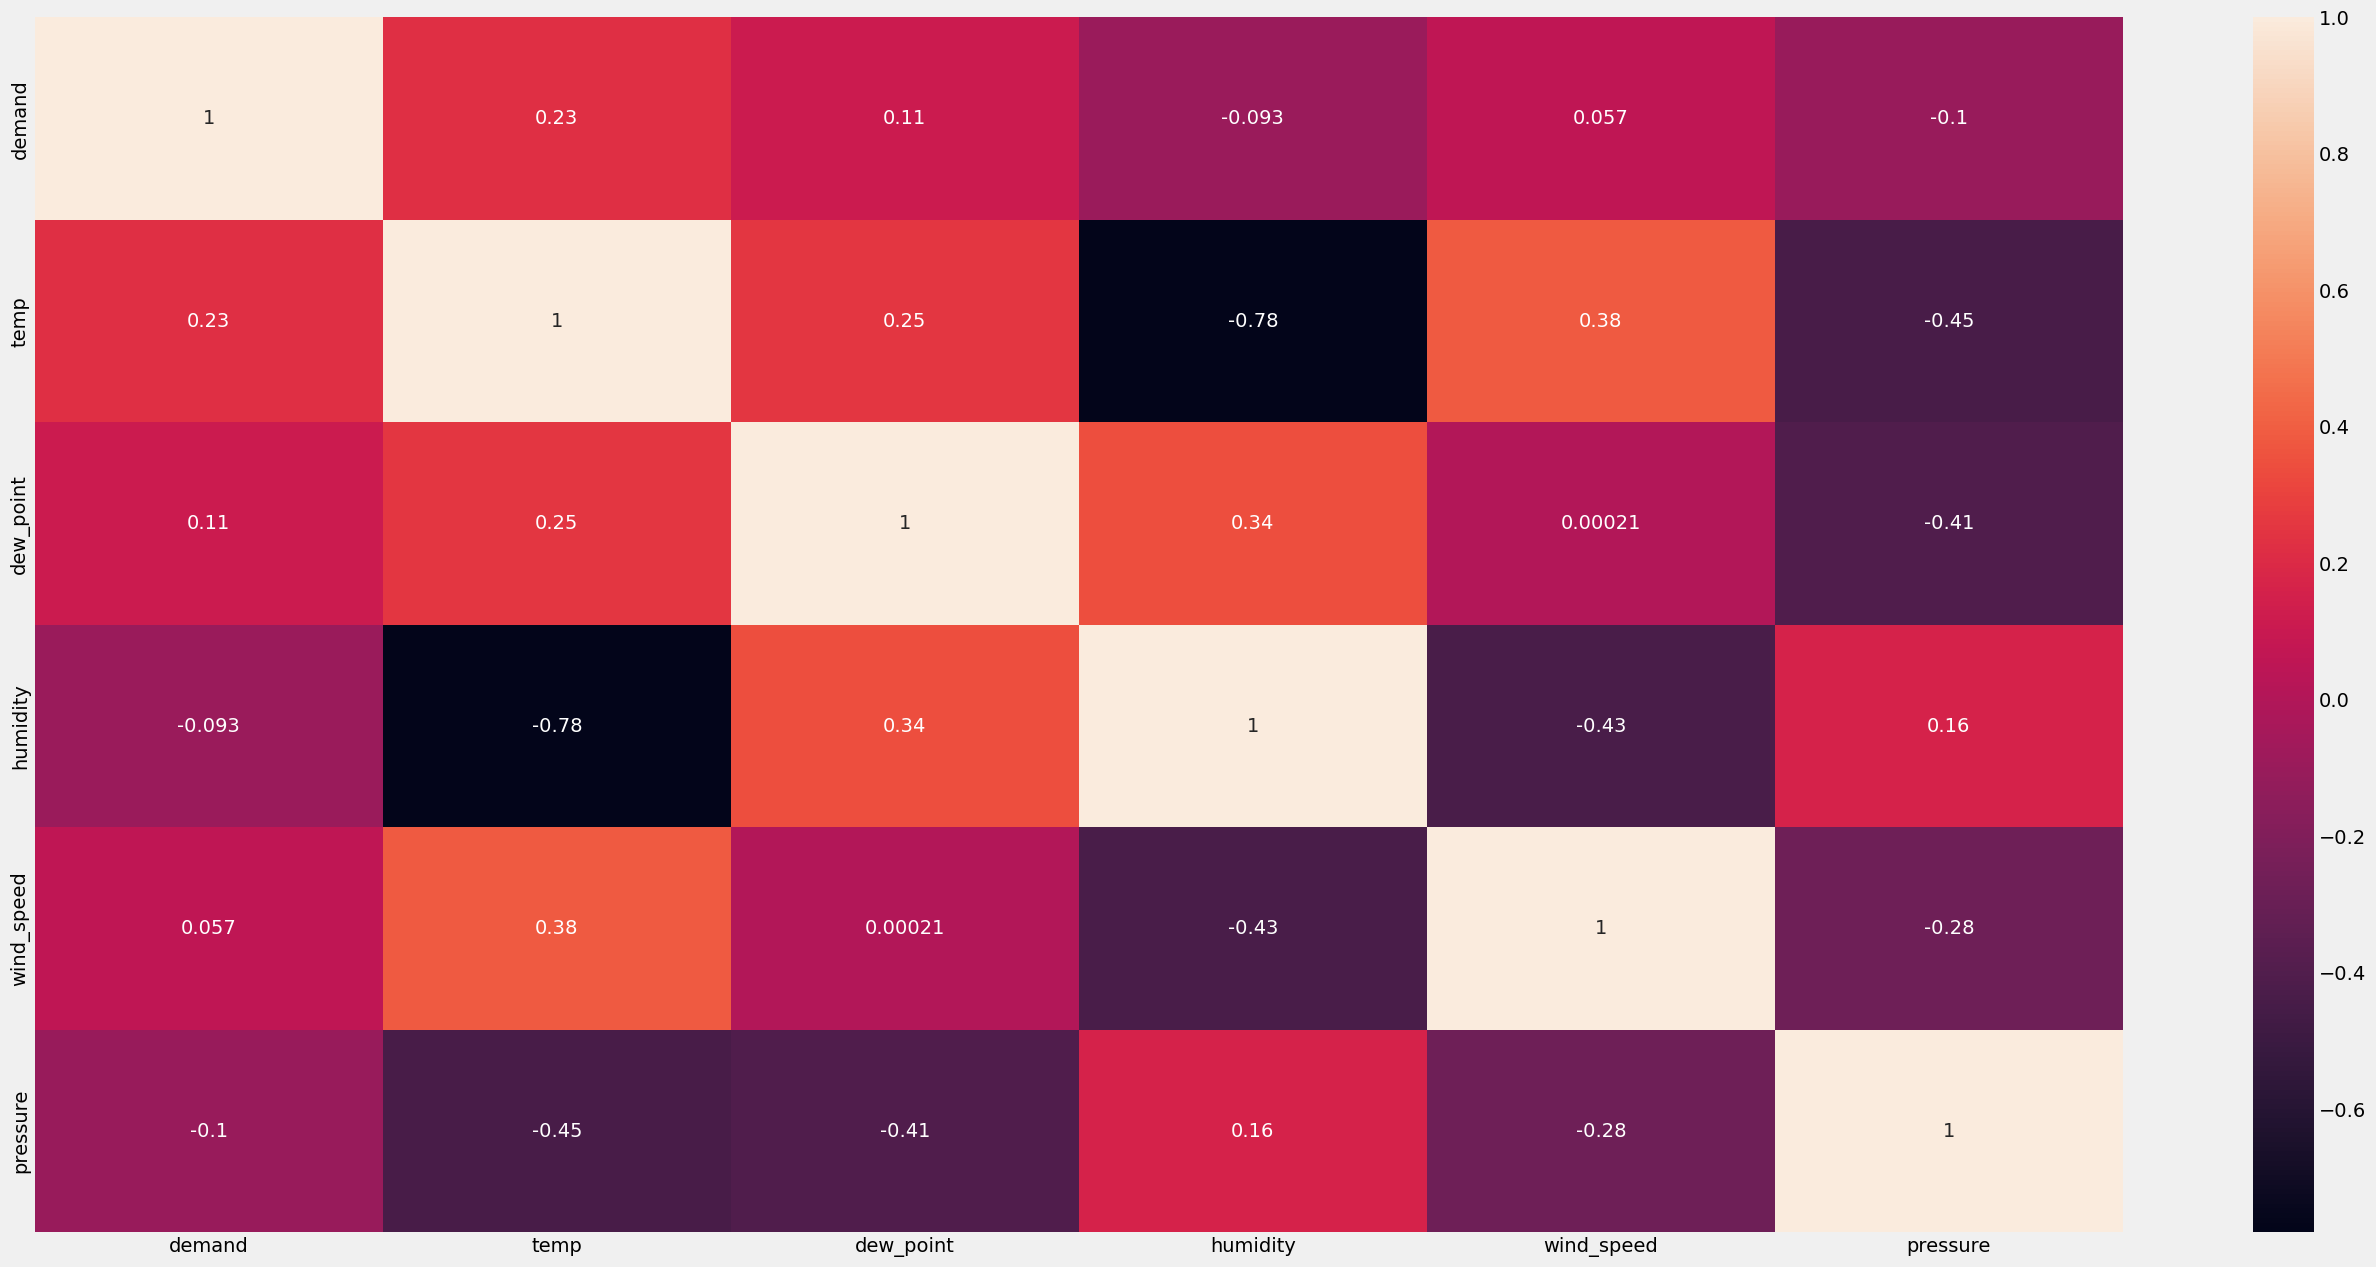

In [15]:
plt.figure(figsize=(30,15))
sns.heatmap(df1.corr(), annot=True)

As we can see temp has highest correlation with demand which is 0.23 only. Lets try to explore the Date features like hour, day, week of the yaer, is working day and holiday to see how it affect the demand.

# Defining Used Function

In [16]:
df1['hour'] = df1['Date'].dt.hour
df1['day'] = df1['Date'].dt.dayofyear
df1['week'] = df1['Date'].dt.week
df1['month'] = df1['Date'].dt.month
df1['weekday'] = df1['Date'].dt.day_name()

#dictionary for useful variables
#France's Holidays
AU_holidays = holidays.AUS()
df1['holiday'] = [1 if d in AU_holidays else 0 for d in df1['Date']]
df1[df1['holiday'] == 1]

df1['isWorkDay'] = df1.apply(lambda x: 'no' if ((x['holiday'] == 1) or
                                          (x['weekday'] in ['Sunday', 'Saturday'])) else 'yes', axis=1)

avg_temp = df1['temp'].mean()
#df1['Gr_avgTemp'] = ['Above' if t > avg_temp else 'Below' for t in df1['apparent_tmp [Kelvin]']]

cat_cols = ['hour','day','week','month','weekday','holiday','isWorkDay','condition']
for col in cat_cols:
  df1[col] = df1[col].astype('category')

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45432 entries, 0 to 45431
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        45432 non-null  datetime64[ns]
 1   demand      45432 non-null  float64       
 2   temp        45432 non-null  float64       
 3   dew_point   45432 non-null  float64       
 4   humidity    45432 non-null  int64         
 5   wind_speed  45432 non-null  int64         
 6   pressure    45432 non-null  int64         
 7   condition   45432 non-null  category      
 8   hour        45432 non-null  category      
 9   day         45432 non-null  category      
 10  week        45432 non-null  category      
 11  month       45432 non-null  category      
 12  weekday     45432 non-null  category      
 13  holiday     45432 non-null  category      
 14  isWorkDay   45432 non-null  category      
dtypes: category(8), datetime64[ns](1), float64(3), int64(3)
memory usage: 

In [18]:
#creating merics to measure model performance
def metric(y_pred, y_actual, model_name = None):

  print('\nError metrics for {}'.format(model_name))

  R2 = m.r2_score(y_pred, y_actual)
  print('R2 Score: %.2f' % R2)

  MSE = m.mean_squared_error(y_pred, y_actual)
  print('Mean Squared Error: %.2f' % MSE)

  RMSE = sqrt(MSE)
  print('\nRoot Mean Squared Error: %.2f' % RMSE)

  MAE = m.mean_absolute_error(y_pred, y_actual)
  print('Mean Absolute Error: %.2f' % MAE)

  MAPE = m.mean_absolute_percentage_error(y_pred, y_actual)
  print('Mean Absolute Percentage Error: %.4f' % MAPE)

def plot_pred_vs_actual(y_pred, y_actual, model_name=None):
  fig, ax = plt.subplots(1,1, figsize=(15,10))
  ax.scatter(y_pred, y_actual)
  _ = plt.xlabel('Actual Demand [mW]')
  _ = plt.ylabel('Predicted Demand [mW]')
  _ = plt.title('Actual Vs Predicted Demand [mW] for {} model'.format(model_name))
  _ = plt.xlim(1000, 10000)
  _ = plt.ylim(1000, 10000)
  X = np.linspace(*ax.get_xlim())
  _ = ax.plot(X,X)
def coef_plot(val, model, model_name = None):
  _ = plt.figure(figsize=(15,10))
  _ = plt.plot(range(len(val.columns)), model.coef_)
  _ = plt.xticks(range(len(val.columns)), val.columns, rotation = 90)
  _ = plt.margins(0.01)
  _ = plt.axhline(0, linewidth = 0.5, color = 'r')
  _ = plt.xlabel('{} coef'.format(model_name))
  _ = plt.ylabel('features')
  _ = plt.title("Coefficients of {}'s Features". format(model_name))


def split_data(data, test_size = 0.15, col_to_trans = None, scale = False, include_entire_data = False):
  # get train index
  train_index = int(len(data)*(1 - (test_size)))
  samp_data = data.copy()
  if scale and include_entire_data:
    scaler = StandardScaler()
    samp_data[col_to_trans] = scaler.fit_transform(samp_data[col_to_trans])

  X_train = samp_data.drop('demand', axis=1).iloc[:train_index]
  X_test = samp_data.drop('demand', axis =1).iloc[train_index:]
  y_train = samp_data.demand.iloc[:train_index]
  y_test = samp_data.demand.iloc[train_index:]

  if scale and not include_entire_data:
    scaler = StandardScaler()
    X_train[col_to_trans] = scaler.fit_transform(X_train[col_to_trans])
    X_test[col_to_trans] = scaler.transform(X_test[col_to_trans])

  return X_train, X_test, y_train, y_test


In [20]:
df1

,Date,demand,temp,dew_point,humidity,wind_speed,pressure,condition,hour,day,week,month,weekday,holiday,isWorkDay
0,2017-01-01 00:00:00,3474.570,21.11,7.78,43,10,29,Fair,0,1,52,1,Sunday,1,no
1,2017-01-01 01:00:00,3371.978,21.11,7.22,40,21,29,Fair / Windy,1,1,52,1,Sunday,1,no
2,2017-01-01 02:00:00,3287.374,20.00,7.78,46,20,29,Fair,2,1,52,1,Sunday,1,no
3,2017-01-01 03:00:00,3218.992,17.78,8.89,56,20,29,Fair,3,1,52,1,Sunday,1,no
4,2017-01-01 04:00:00,3203.696,17.22,8.89,59,23,29,Fair / Windy,4,1,52,1,Sunday,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45427,2022-03-08 19:00:00,6038.368,23.90,15.00,57,13,29,Fair,19,67,10,3,Tuesday,0,yes
45428,2022-03-08 20:00:00,5602.400,23.90,15.00,57,13,29,Fair,20,67,10,3,Tuesday,0,yes
45429,2022-03-08 21:00:00,5109.266,23.90,15.00,57,13,29,Fair,21,67,10,3,Tuesday,0,yes
45430,2022-03-08 22:00:00,4613.252,23.90,15.00,57,13,29,Fair,22,67,10,3,Tuesday,0,yes


We will try the baseline linear regression model to see how it works with our dataset.

# Model Design- Ordinary least squares

In [21]:
model = ols('demand ~ C(month) + C(hour) + C(condition) + C(holiday) + C(isWorkDay) \
            + C(week) + temp + wind_speed + humidity + dew_point + pressure\
                + C(day)+C(week)', df1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     197.0
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:21:15   Log-Likelihood:            -3.4178e+05
No. Observations:               45432   AIC:                         6.846e+05
Df Residuals:                   44930   BIC:                         6.889e+05
Df Model:                         501                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [22]:
model1 = ols('demand ~ C(month) + C(hour) +  C(holiday) + C(isWorkDay) \
            + C(week) + temp + humidity + dew_point + pressure\
                +C(week)', df1).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     974.8
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:21:18   Log-Likelihood:            -3.4339e+05
No. Observations:               45432   AIC:                         6.870e+05
Df Residuals:                   45339   BIC:                         6.878e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1409.3397    

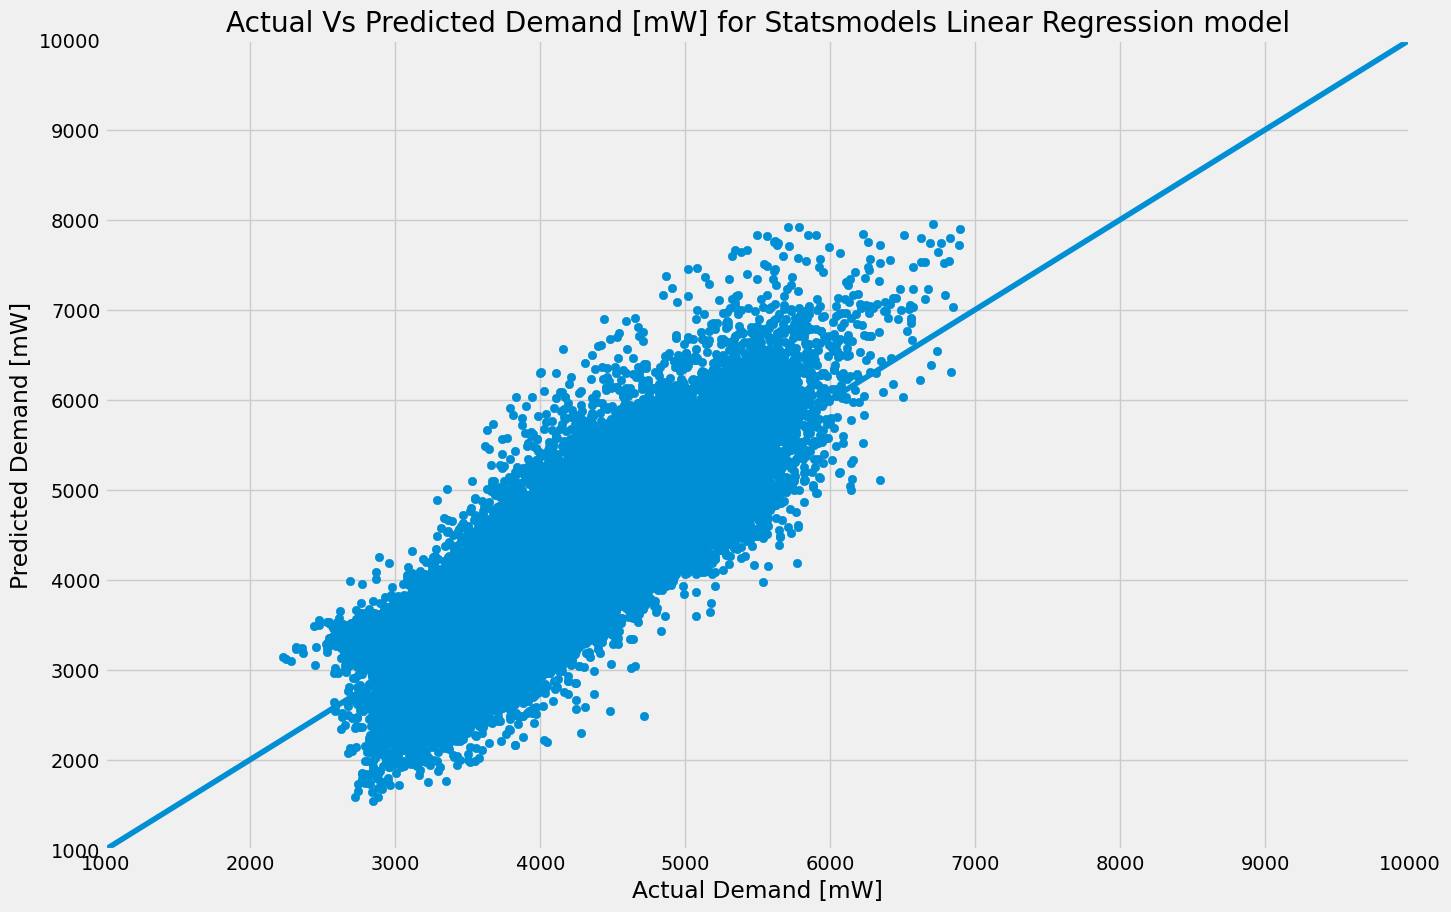

In [23]:
plot_pred_vs_actual(model.fittedvalues, df1.demand, model_name = 'Statsmodels Linear Regression')

In [24]:
used_cols = ['Date','demand','month','hour','holiday','isWorkDay','week']

In [25]:
sk_df = pd.get_dummies(df1[used_cols], drop_first=True)
sk_df = sk_df.set_index('Date')
sk_df

,demand,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,3474.570,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2017-01-01 01:00:00,3371.978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2017-01-01 02:00:00,3287.374,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2017-01-01 03:00:00,3218.992,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2017-01-01 04:00:00,3203.696,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08 19:00:00,6038.368,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-08 20:00:00,5602.400,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-08 21:00:00,5109.266,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#col_to_trans = ['temp' , 'humidity' , 'dew_point' ]
X_train, X_test, y_train, y_test = split_data(sk_df, test_size=0.15, include_entire_data=False)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

metric(lr.predict(X_train), y_train, 'Sklearn Linear Regression training data')
metric(pred, y_test, 'Sklearn Linear Regression test data')


Error metrics for Sklearn Linear Regression training data
R2 Score: 0.38
Mean Squared Error: 215498.21

Root Mean Squared Error: 464.22
Mean Absolute Error: 342.50
Mean Absolute Percentage Error: 0.0851

Error metrics for Sklearn Linear Regression test data
R2 Score: -0.48
Mean Squared Error: 527621.13

Root Mean Squared Error: 726.38
Mean Absolute Error: 537.84
Mean Absolute Percentage Error: 0.1337


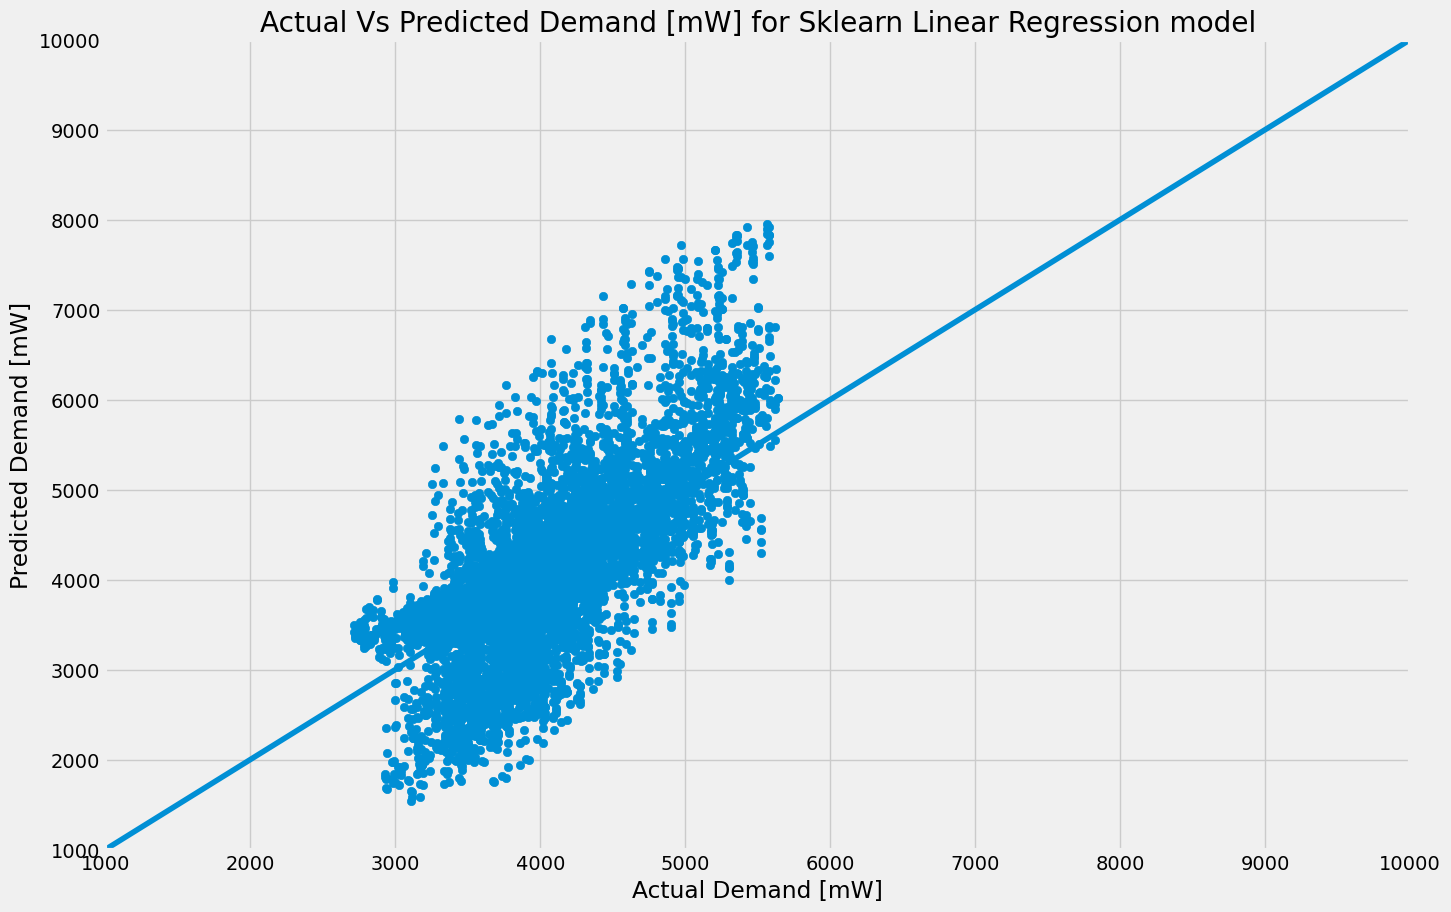

In [27]:
plot_pred_vs_actual(pred, y_test,model_name='Sklearn Linear Regression')

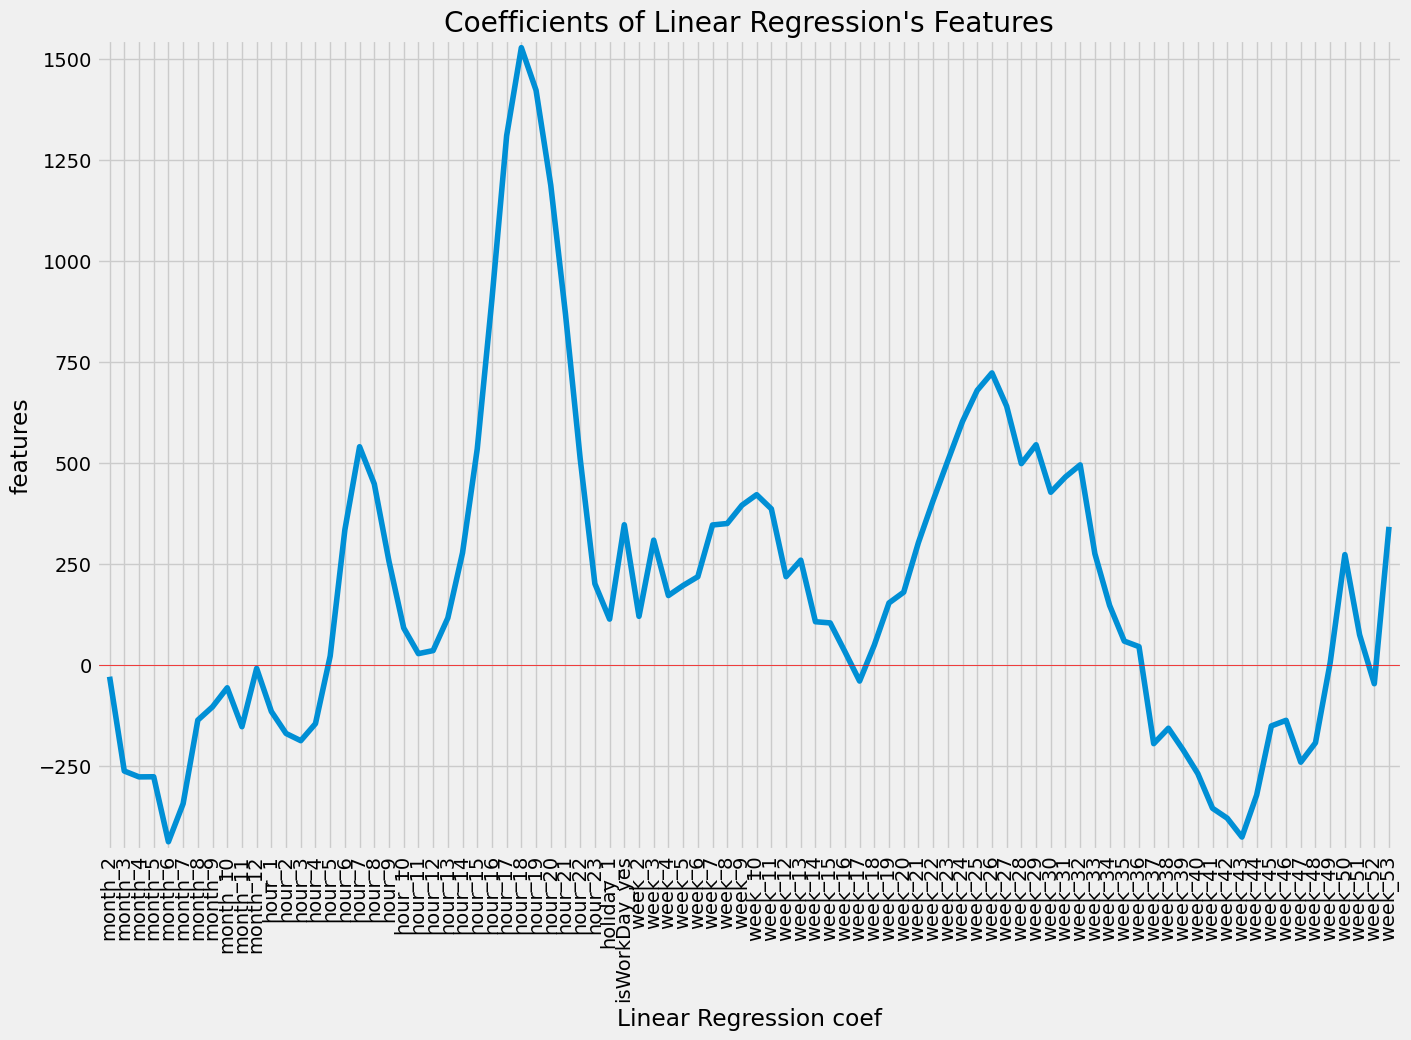

In [28]:
coef_plot(X_train, lr, 'Linear Regression')

We can see OLS model is not performing well. We will check our model against Persistent model. We can check for a year ago model, a week model and an hour model.

# Persistent(Repeat values from one year ago) model

In [29]:
naive_pred = sk_df.loc[X_test.index.shift(-8760, freq='H'),'demand']
metric(naive_pred[0:], y_test, 'Naive or Persistent model')  #leap year


Error metrics for Naive or Persistent model
R2 Score: 0.26
Mean Squared Error: 518114.52

Root Mean Squared Error: 719.80
Mean Absolute Error: 500.03
Mean Absolute Percentage Error: 0.1290


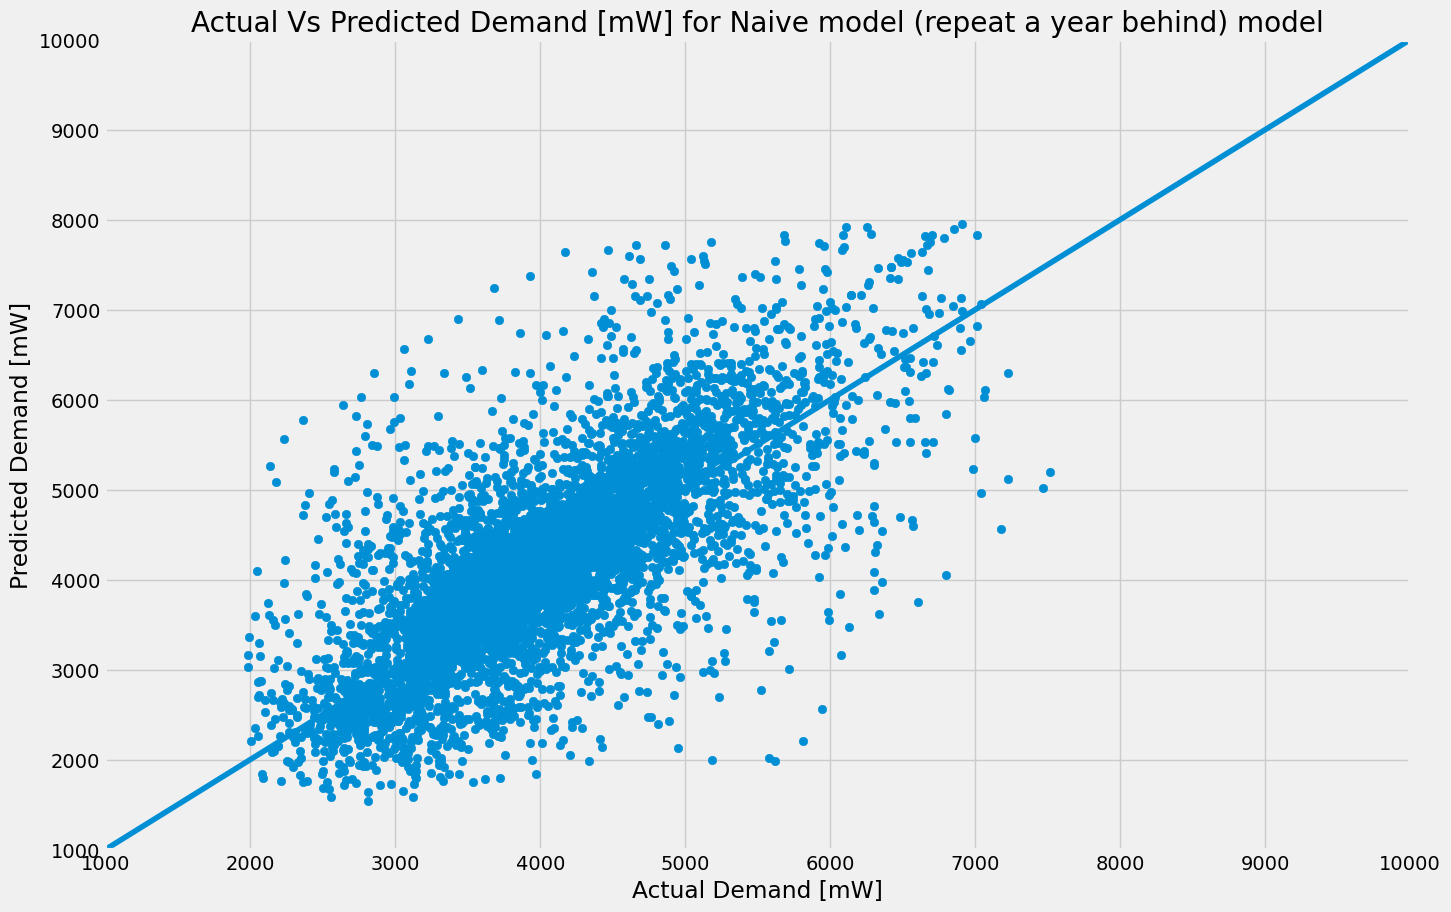

In [30]:
plot_pred_vs_actual(naive_pred[0:], y_test,model_name='Naive model (repeat a year behind)')

## Persistent (Repeat last hour) model

In [31]:
# one hour ahead for cast
naive_pred2 = sk_df.loc[X_test.index.shift(-1, freq='H'), 'demand']
metric(naive_pred2[0:], y_test, 'last hour naive forcast')


Error metrics for last hour naive forcast
R2 Score: 0.89
Mean Squared Error: 118302.30

Root Mean Squared Error: 343.95
Mean Absolute Error: 274.51
Mean Absolute Percentage Error: 0.0681


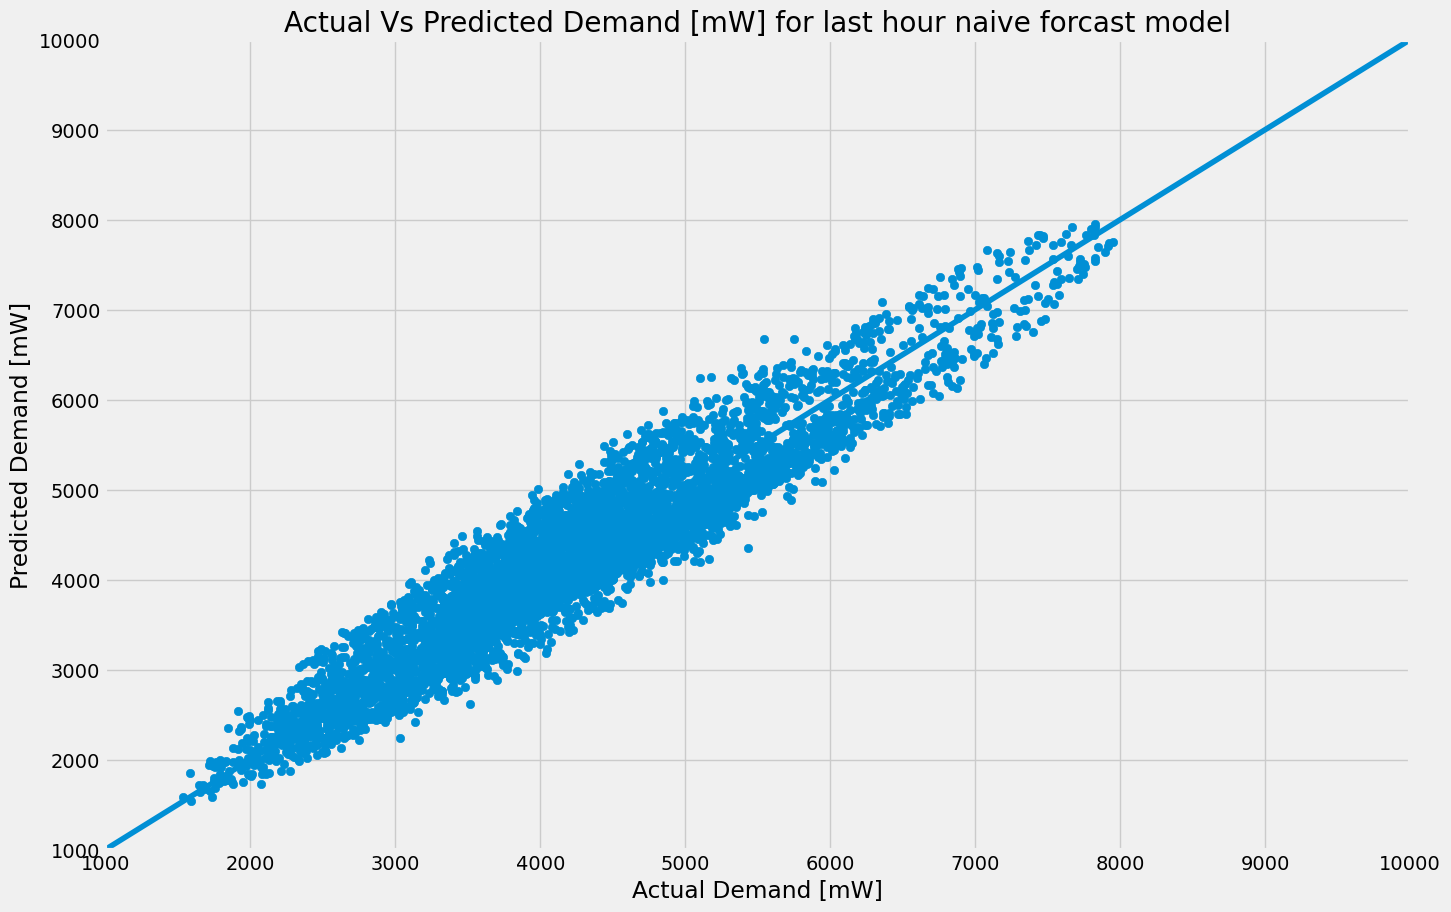

In [32]:
plot_pred_vs_actual(naive_pred2[0:], y_test, model_name='last hour naive forcast')

## Persistent (Repeat last one week) model

In [33]:
# one week ahead for cast
naive_pred3 = sk_df.loc[X_test.index.shift(-168, freq='H'), 'demand']
metric(naive_pred3[0:], y_test, 'last week naive forcast')


Error metrics for last week naive forcast
R2 Score: 0.38
Mean Squared Error: 661687.50

Root Mean Squared Error: 813.44
Mean Absolute Error: 535.01
Mean Absolute Percentage Error: 0.1331


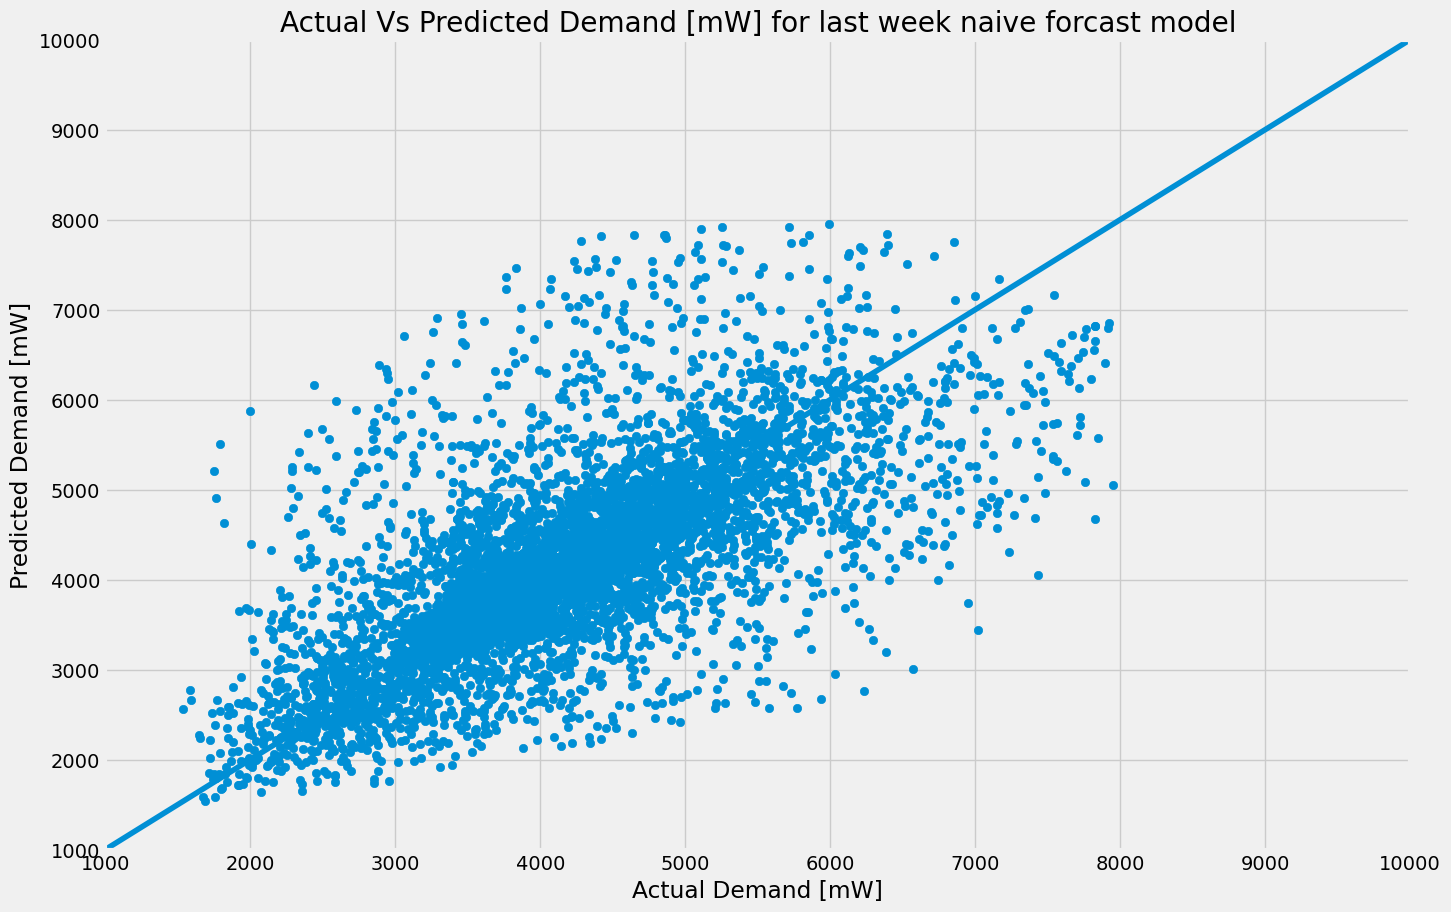

In [34]:
plot_pred_vs_actual(naive_pred3[0:], y_test, model_name='last week naive forcast')

We can see that one hour model is better than others with MAPE of 6.81.

As we can see temprature and other weather data has less affect on demand, also to keep our model simle and explainable, I will use only Date's feature in the model. This will also remove our depencence on weather data. As BOM forecast are not available in 1 hr or 30 min format for next 7 days, we will be restricted to use our model to limited prediction. To avoid all these pitfall we will try only demand and date data which is also available on AEMO website. Lets see how it works

# Adding 24 hours Lag

In [35]:
#with and without wind speed has been tried, the latter was the optimal
cols_used = ['Date','demand', 'holiday','isWorkDay','week','hour','month']
lag_df = df1[cols_used].set_index('Date')
lag_df['isWorkDay'] = [0 if t == 'no' else 1 for t in lag_df['isWorkDay']]

In [36]:
# getting 24 hours lag
for i in range(24):
  lag_df['lag' + str(i+1)] = lag_df['demand'].shift(i+1)
#drop the first 24 hours NaN values
lag = lag_df.dropna()

In [37]:
#cols_to_trans = ['humidity' , 'dew_point' , 'pressure']
lags_list = ['lag' + str(i+1) for i in range(24)]
#cols_to_trans.extend(lags_list)
X_train, X_test, y_train, y_test = split_data(lag,test_size=0.15,                                              
                                              include_entire_data=False)

#  Analysis

In [38]:
min, max = lag.index.min(), lag.index.max()
data = lag.copy()
data['Date'] = pd.date_range(start = min, end = max, freq='H')
demand_data = data[['demand']]

def decopose_df(df):
  decompose = seasonal_decompose(df)
  fig = decompose.plot()
  fig.set_size_inches(25,12)
  fig.tight_layout()
  plt.show()

def metricf(fcast, test):
  mae = m.mean_absolute_error(test,fcast)
  print('MAE : %3f' % mae)
  mse = m.mean_squared_error(test,fcast)
  print('MSE : %3f' % mse)
  rmse = sqrt(mse)
  print('RMSE : %3f' % rmse)
  mape = m.mean_absolute_percentage_error(test,fcast)
  print('MAPE : %3f' % mape)


def split_data_fcast(X,y):
  X_train, X_test, y_train, y_test = X[:-2305], X[-2305:], y[:-2305], y[-2305:]
  return X_train, X_test, y_train, y_test


def split_sequence_mult(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ts = i + n_steps_in
    out_ts = end_ts + n_steps_out -1 
    if out_ts > len(sequence):
      break;
    seqx, seqy = sequence.iloc[i:end_ts, 1:], sequence.iloc[end_ts-1:out_ts, 0]
    X.append(seqx)
    y.append(seqy)
  return array(X), array(y)

def plot_result(yhat, test, model_name = None):
  pred = array([i for i in yhat]).reshape(-1,1)
  tester = array([i for i in test]).reshape(-1,1)
  pred = pd.DataFrame(pred)
  tester = pd.DataFrame(tester)
  result = pd.concat([pred, tester],ignore_index=True, axis=1)
  plt.figure(figsize=(25,18))
  plt.plot(result[0], color = 'blue', label="Forecasted Demand")
  plt.plot(result[1],color = 'green', label="Actual Demand")
  plt.legend(loc='upper left')
  plt.title('Forecasted and Actual Demand of {}'.format(model_name))
  plt.xlabel('Hours')
  plt.ylabel('Demand')
  print('Accuracy: {}'.format(m.r2_score(pred, tester)))

## 24 hours ahead forecast

In [39]:
#cols = ['humidity' , 'dew_point' , 'pressure']
lags_list = ['lag' + str(i+1) for i in range(24)]
#cols.extend(lags_list)

scaler = StandardScaler()
#lag[cols] = scaler.fit_transform(lag[cols])

In [40]:
n_steps_in, n_steps_out = 48,24
X, y = split_sequence_mult(lag, n_steps_in=n_steps_in,n_steps_out=n_steps_out)

In [41]:
#flatten inputs
n_inputs, n_out = X.shape[1] * X.shape[2], 24
XC = X.reshape(X.shape[0], n_inputs)

X_train, X_test, y_train, y_test = split_data_fcast(XC,y)

In [42]:
XC.shape

(45338, 1392)

# MLP model (48-in, 24 out)

In [43]:
rn.seed(24)
tf.random.set_seed(24)

MLP_model = Sequential()
MLP_model.add(Dense(800, activation='relu', input_dim=n_inputs))
MLP_model.add(Dense(n_out))
MLP_model.compile(optimizer='adam', loss='mse')
MLP_model.fit(X_train, y_train, epochs=100, verbose=1)




Epoch 1/100
1345/1345 [==============================] - 10s 7ms/step - loss: 400641.8125
Epoch 2/100
1345/1345 [==============================] - 10s 7ms/step - loss: 179521.3906
Epoch 3/100
1345/1345 [==============================] - 10s 7ms/step - loss: 169926.8594
Epoch 4/100
1345/1345 [==============================] - 9s 7ms/step - loss: 164812.7969
Epoch 5/100
1345/1345 [==============================] - 9s 6ms/step - loss: 159234.7812
Epoch 6/100
1345/1345 [==============================] - 8s 6ms/step - loss: 155354.1406
Epoch 7/100
1345/1345 [==============================] - 9s 7ms/step - loss: 152806.0312
Epoch 8/100
1345/1345 [==============================] - 8s 6ms/step - loss: 150798.5625
Epoch 9/100
1345/1345 [==============================] - 9s 7ms/step - loss: 150671.4219
Epoch 10/100
1345/1345 [==============================] - 9s 7ms/step - loss: 146546.3750
Epoch 11/100
1345/1345 [==============================] - 8s 6ms/step - loss: 146692.3594
Epoch 12/100
134

1345/1345 [==============================] - 8s 6ms/step - loss: 124600.7734
Epoch 93/100
1345/1345 [==============================] - 8s 6ms/step - loss: 127227.8750
Epoch 94/100
1345/1345 [==============================] - 8s 6ms/step - loss: 125450.0625
Epoch 95/100
1345/1345 [==============================] - 8s 6ms/step - loss: 126170.7031
Epoch 96/100
1345/1345 [==============================] - 7s 5ms/step - loss: 125771.1406
Epoch 97/100
1345/1345 [==============================] - 9s 7ms/step - loss: 125967.1562
Epoch 98/100
1345/1345 [==============================] - 8s 6ms/step - loss: 125548.9219
Epoch 99/100
1345/1345 [==============================] - 8s 6ms/step - loss: 124791.3672
Epoch 100/100
1345/1345 [==============================] - 10s 7ms/step - loss: 126375.0625


In [44]:
yhat=MLP_model.predict(X_test)
test = y_test
metricf(yhat, test)

MAE : 368.904456
MSE : 264787.856115
RMSE : 514.575413
MAPE : 0.086765


In [45]:
pred = array([i for i in yhat]).reshape(-1,1)
tester = array([i for i in test]).reshape(-1,1)
pred = pd.DataFrame(pred)
tester = pd.DataFrame(tester)
result = pd.concat([pred, tester],ignore_index=True, axis=1)
#result[:55]

,0,1
0,3439.000732,3515.176
1,3456.545410,3446.972
2,3466.763672,3402.796
3,3442.633545,3389.762
4,3450.043213,3452.726
5,3532.764160,3532.124
6,3569.878662,3582.000
7,3448.118164,3377.256
8,3198.633301,2964.630
9,2861.167236,2619.814


In [47]:
final_result=result.iloc[::24, :]
final_result.rename(columns={0 : 'Prediction',1: "Actual"}, inplace=True)
#final_result[:15]

,Prediction,Actual
0,3439.000732,3515.176
24,3292.036865,3446.972
48,3263.606201,3402.796
72,3298.872559,3389.762
96,3388.505859,3452.726
120,3423.242188,3532.124
144,3430.515137,3582.000
168,3287.824219,3377.256
192,2953.744629,2964.630
216,2612.194336,2619.814


In [48]:
final_result['date'] = pd.date_range(start='2021-12-01', periods=len(final_result), freq='H')
final_result

,Prediction,Actual,date
0,3439.000732,3515.176,2021-12-01 00:00:00
24,3292.036865,3446.972,2021-12-01 01:00:00
48,3263.606201,3402.796,2021-12-01 02:00:00
72,3298.872559,3389.762,2021-12-01 03:00:00
96,3388.505859,3452.726,2021-12-01 04:00:00
...,...,...,...
55200,5717.662109,5692.854,2022-03-06 20:00:00
55224,5202.836426,5124.244,2022-03-06 21:00:00
55248,4687.950195,4615.516,2022-03-06 22:00:00
55272,4201.655273,4251.246,2022-03-06 23:00:00


In [49]:
#metricf(final_result["Prediction"], final_result["Actual"])

MAE : 181.338736
MSE : 54646.171995
RMSE : 233.765207
MAPE : 0.042775


In [50]:
final_result['date'] = pd.to_datetime(final_result['date'])
final_result["Date"] = pd.to_datetime(final_result['date']).dt.date

In [51]:
agg_1 = pd.DataFrame(final_result.groupby(['Date'])["Prediction"].sum().reset_index())
agg_2= pd.DataFrame(final_result.groupby(['Date'])["Actual"].sum().reset_index())

In [52]:
df_merged = pd.merge(agg_1, agg_2, on='Date', how='inner')
#df_merged

,Date,Prediction,Actual
0,2021-12-01,81648.921875,83692.208
1,2021-12-02,85024.796875,87674.768
2,2021-12-03,85586.570312,86230.014
3,2021-12-04,84542.242188,83724.146
4,2021-12-05,91945.523438,93863.772
...,...,...,...
92,2022-03-03,85770.085938,87786.444
93,2022-03-04,87926.445312,89077.488
94,2022-03-05,92190.148438,93176.432
95,2022-03-06,100524.101562,101534.272


In [53]:
df_merged[df_merged["Prediction"].gt(136663)]

,Date,Prediction,Actual
48,2022-01-18,139847.43750,143929.714
50,2022-01-20,136807.43750,141839.600
64,2022-02-03,137227.18750,142620.646
76,2022-02-15,137031.15625,143068.538


In [54]:
#df_merged.sort_values(by=['Prediction']).tail(5)

,Date,Prediction,Actual
25,2021-12-26,135880.87500,139702.954
50,2022-01-20,136807.43750,141839.600
76,2022-02-15,137031.15625,143068.538
64,2022-02-03,137227.18750,142620.646
48,2022-01-18,139847.43750,143929.714


In [55]:
#df_merged["Prediction"].nlargest(n=5)

48    139847.43750
64    137227.18750
76    137031.15625
50    136807.43750
25    135880.87500
Name: Prediction, dtype: float32

In [56]:
#df_merged.sort_values(by=['Actual']).tail(5)

,Date,Prediction,Actual
25,2021-12-26,135880.87500,139702.954
50,2022-01-20,136807.43750,141839.600
64,2022-02-03,137227.18750,142620.646
76,2022-02-15,137031.15625,143068.538
48,2022-01-18,139847.43750,143929.714


Accuracy: 0.9535509928267121


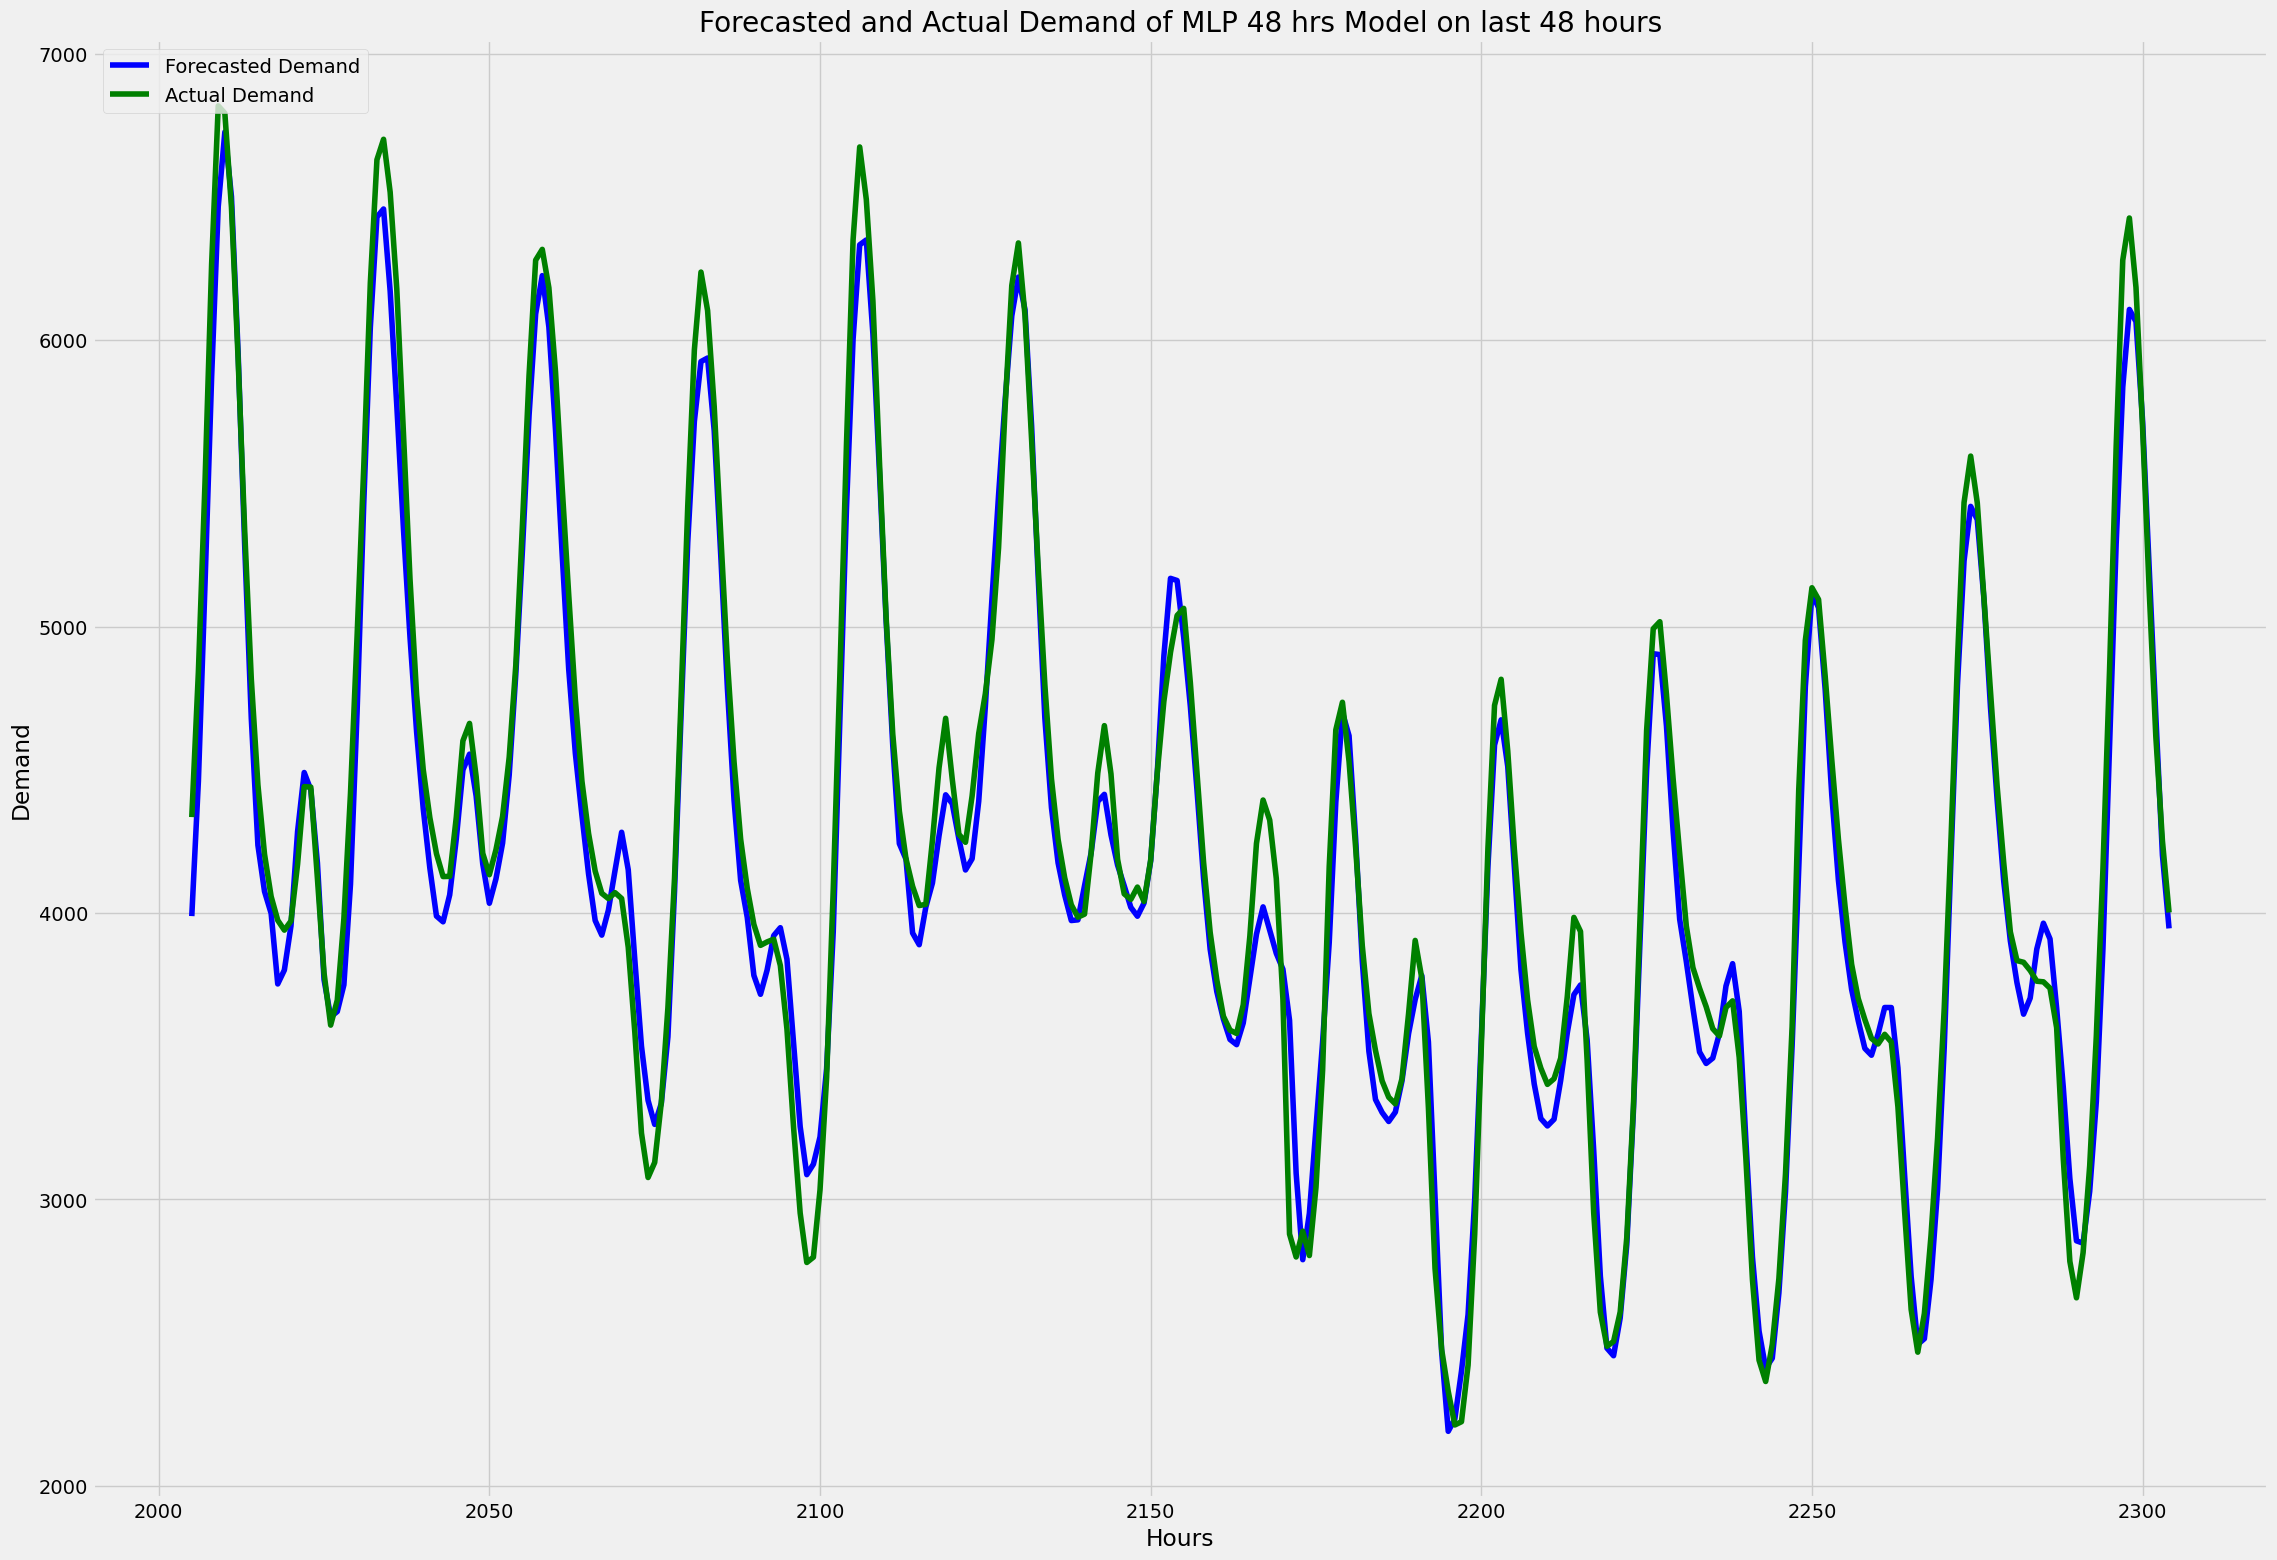

In [57]:
plot_result(final_result["Prediction"][-48:], final_result["Actual"][-48:], 'MLP 48 hrs Model on last 48 hours')

# CNN model (48 in 24 out)

In [60]:
rn.seed(24)
tf.random.set_seed(24)


n_in, n_out = 48, 24
#X,y = split_sequence_mult(lag,n_in, n_out)
X_train, X_test, y_train, y_test = split_data_fcast(X,y)
n_features = 29

In [61]:
X_train.shape

(43033, 48, 29)

In [62]:

# define model
CNN_model = Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_in,
n_features)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(800, activation='relu'))
CNN_model.add(Dense(n_out))
CNN_model.compile(optimizer='adam', loss='mse')
# fit model
CNN_model.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
1345/1345 [==============================] - 17s 12ms/step - loss: 201580.9219
Epoch 2/100
1345/1345 [==============================] - 18s 13ms/step - loss: 141273.7969
Epoch 3/100
1345/1345 [==============================] - 18s 13ms/step - loss: 130731.8047
Epoch 4/100
1345/1345 [==============================] - 16s 12ms/step - loss: 123993.5938
Epoch 5/100
1345/1345 [==============================] - 14s 11ms/step - loss: 119360.1562
Epoch 6/100
1345/1345 [==============================] - 13s 9ms/step - loss: 114009.6406
Epoch 7/100
1345/1345 [==============================] - 17s 12ms/step - loss: 111162.5938
Epoch 8/100
1345/1345 [==============================] - 16s 12ms/step - loss: 109329.3984
Epoch 9/100
1345/1345 [==============================] - 12s 9ms/step - loss: 106706.3203
Epoch 10/100
1345/1345 [==============================] - 13s 10ms/step - loss: 104107.2344
Epoch 11/100
1345/1345 [==============================] - 13s 10ms/step - loss: 102745.8594

1345/1345 [==============================] - 14s 11ms/step - loss: 72758.7812
Epoch 92/100
1345/1345 [==============================] - 22s 17ms/step - loss: 71863.2656
Epoch 93/100
1345/1345 [==============================] - 25s 19ms/step - loss: 71425.3984
Epoch 94/100
1345/1345 [==============================] - 25s 19ms/step - loss: 71631.5703
Epoch 95/100
1345/1345 [==============================] - 25s 19ms/step - loss: 72704.5625
Epoch 96/100
1345/1345 [==============================] - 25s 19ms/step - loss: 71435.1328
Epoch 97/100
1345/1345 [==============================] - 25s 19ms/step - loss: 71006.3594
Epoch 98/100
1345/1345 [==============================] - 25s 19ms/step - loss: 70917.4219
Epoch 99/100
1345/1345 [==============================] - 25s 18ms/step - loss: 70317.7500
Epoch 100/100
1345/1345 [==============================] - 25s 19ms/step - loss: 70056.4297


In [63]:
yhat=CNN_model.predict(X_test)
test = y_test
metricf(yhat, test)

MAE : 377.210859
MSE : 272007.407262
RMSE : 521.543294
MAPE : 0.092897


In [64]:
pred = array([i for i in yhat]).reshape(-1,1)
tester = array([i for i in test]).reshape(-1,1)
pred = pd.DataFrame(pred)
tester = pd.DataFrame(tester)
result = pd.concat([pred, tester],ignore_index=True, axis=1)
#result[:55]

,0,1
0,3573.313721,3515.176
1,3465.301270,3446.972
2,3416.250977,3402.796
3,3415.500488,3389.762
4,3445.032959,3452.726
5,3541.931396,3532.124
6,3611.912842,3582.000
7,3466.928223,3377.256
8,3102.108398,2964.630
9,2669.489502,2619.814


In [65]:
final_result=result.iloc[::24, :]
final_result.rename(columns={0 : 'Prediction',1: "Actual"}, inplace=True)
#final_result[:15]

,Prediction,Actual
0,3573.313721,3515.176
24,3480.104736,3446.972
48,3485.371338,3402.796
72,3597.886963,3389.762
96,3564.761963,3452.726
120,3529.054932,3532.124
144,3614.335693,3582.000
168,3427.641113,3377.256
192,3043.152588,2964.630
216,2702.724365,2619.814


In [66]:
final_result['date'] = pd.date_range(start='2021-12-01', periods=len(final_result), freq='H')
#final_result

In [67]:
metricf(final_result["Prediction"], final_result["Actual"])

MAE : 210.529337
MSE : 79281.414659
RMSE : 281.569556
MAPE : 0.053364


In [68]:
final_result['date'] = pd.to_datetime(final_result['date'])
final_result["Date"] = pd.to_datetime(final_result['date']).dt.date

In [69]:
agg_1 = pd.DataFrame(final_result.groupby(['Date'])["Prediction"].sum().reset_index())
agg_2= pd.DataFrame(final_result.groupby(['Date'])["Actual"].sum().reset_index())

In [70]:
df_merged = pd.merge(agg_1, agg_2, on='Date', how='inner')
df_merged

,Date,Prediction,Actual
0,2021-12-01,85022.046875,83692.208
1,2021-12-02,90153.679688,87674.768
2,2021-12-03,90927.726562,86230.014
3,2021-12-04,88718.085938,83724.146
4,2021-12-05,95096.617188,93863.772
...,...,...,...
92,2022-03-03,90079.101562,87786.444
93,2022-03-04,90471.070312,89077.488
94,2022-03-05,97477.742188,93176.432
95,2022-03-06,107497.468750,101534.272


In [71]:
df_merged[df_merged["Prediction"].gt(136663)]

,Date,Prediction,Actual
25,2021-12-26,140706.843750,139702.954
48,2022-01-18,143251.093750,143929.714
49,2022-01-19,146262.203125,139644.016
50,2022-01-20,143026.468750,141839.600
64,2022-02-03,145375.156250,142620.646
75,2022-02-14,140141.937500,137116.820
76,2022-02-15,147911.406250,143068.538
77,2022-02-16,137539.421875,133066.646


In [72]:
#df_merged.sort_values(by=['Prediction']).tail(5)

,Date,Prediction,Actual
50,2022-01-20,143026.468750,141839.600
48,2022-01-18,143251.093750,143929.714
64,2022-02-03,145375.156250,142620.646
49,2022-01-19,146262.203125,139644.016
76,2022-02-15,147911.406250,143068.538


In [73]:
#df_merged["Prediction"].nlargest(n=5)

76    147911.406250
49    146262.203125
64    145375.156250
48    143251.093750
50    143026.468750
Name: Prediction, dtype: float32

In [74]:
#df_merged.sort_values(by=['Actual']).tail(5)

,Date,Prediction,Actual
25,2021-12-26,140706.84375,139702.954
50,2022-01-20,143026.46875,141839.600
64,2022-02-03,145375.15625,142620.646
76,2022-02-15,147911.40625,143068.538
48,2022-01-18,143251.09375,143929.714


Accuracy: 0.9349751533878163


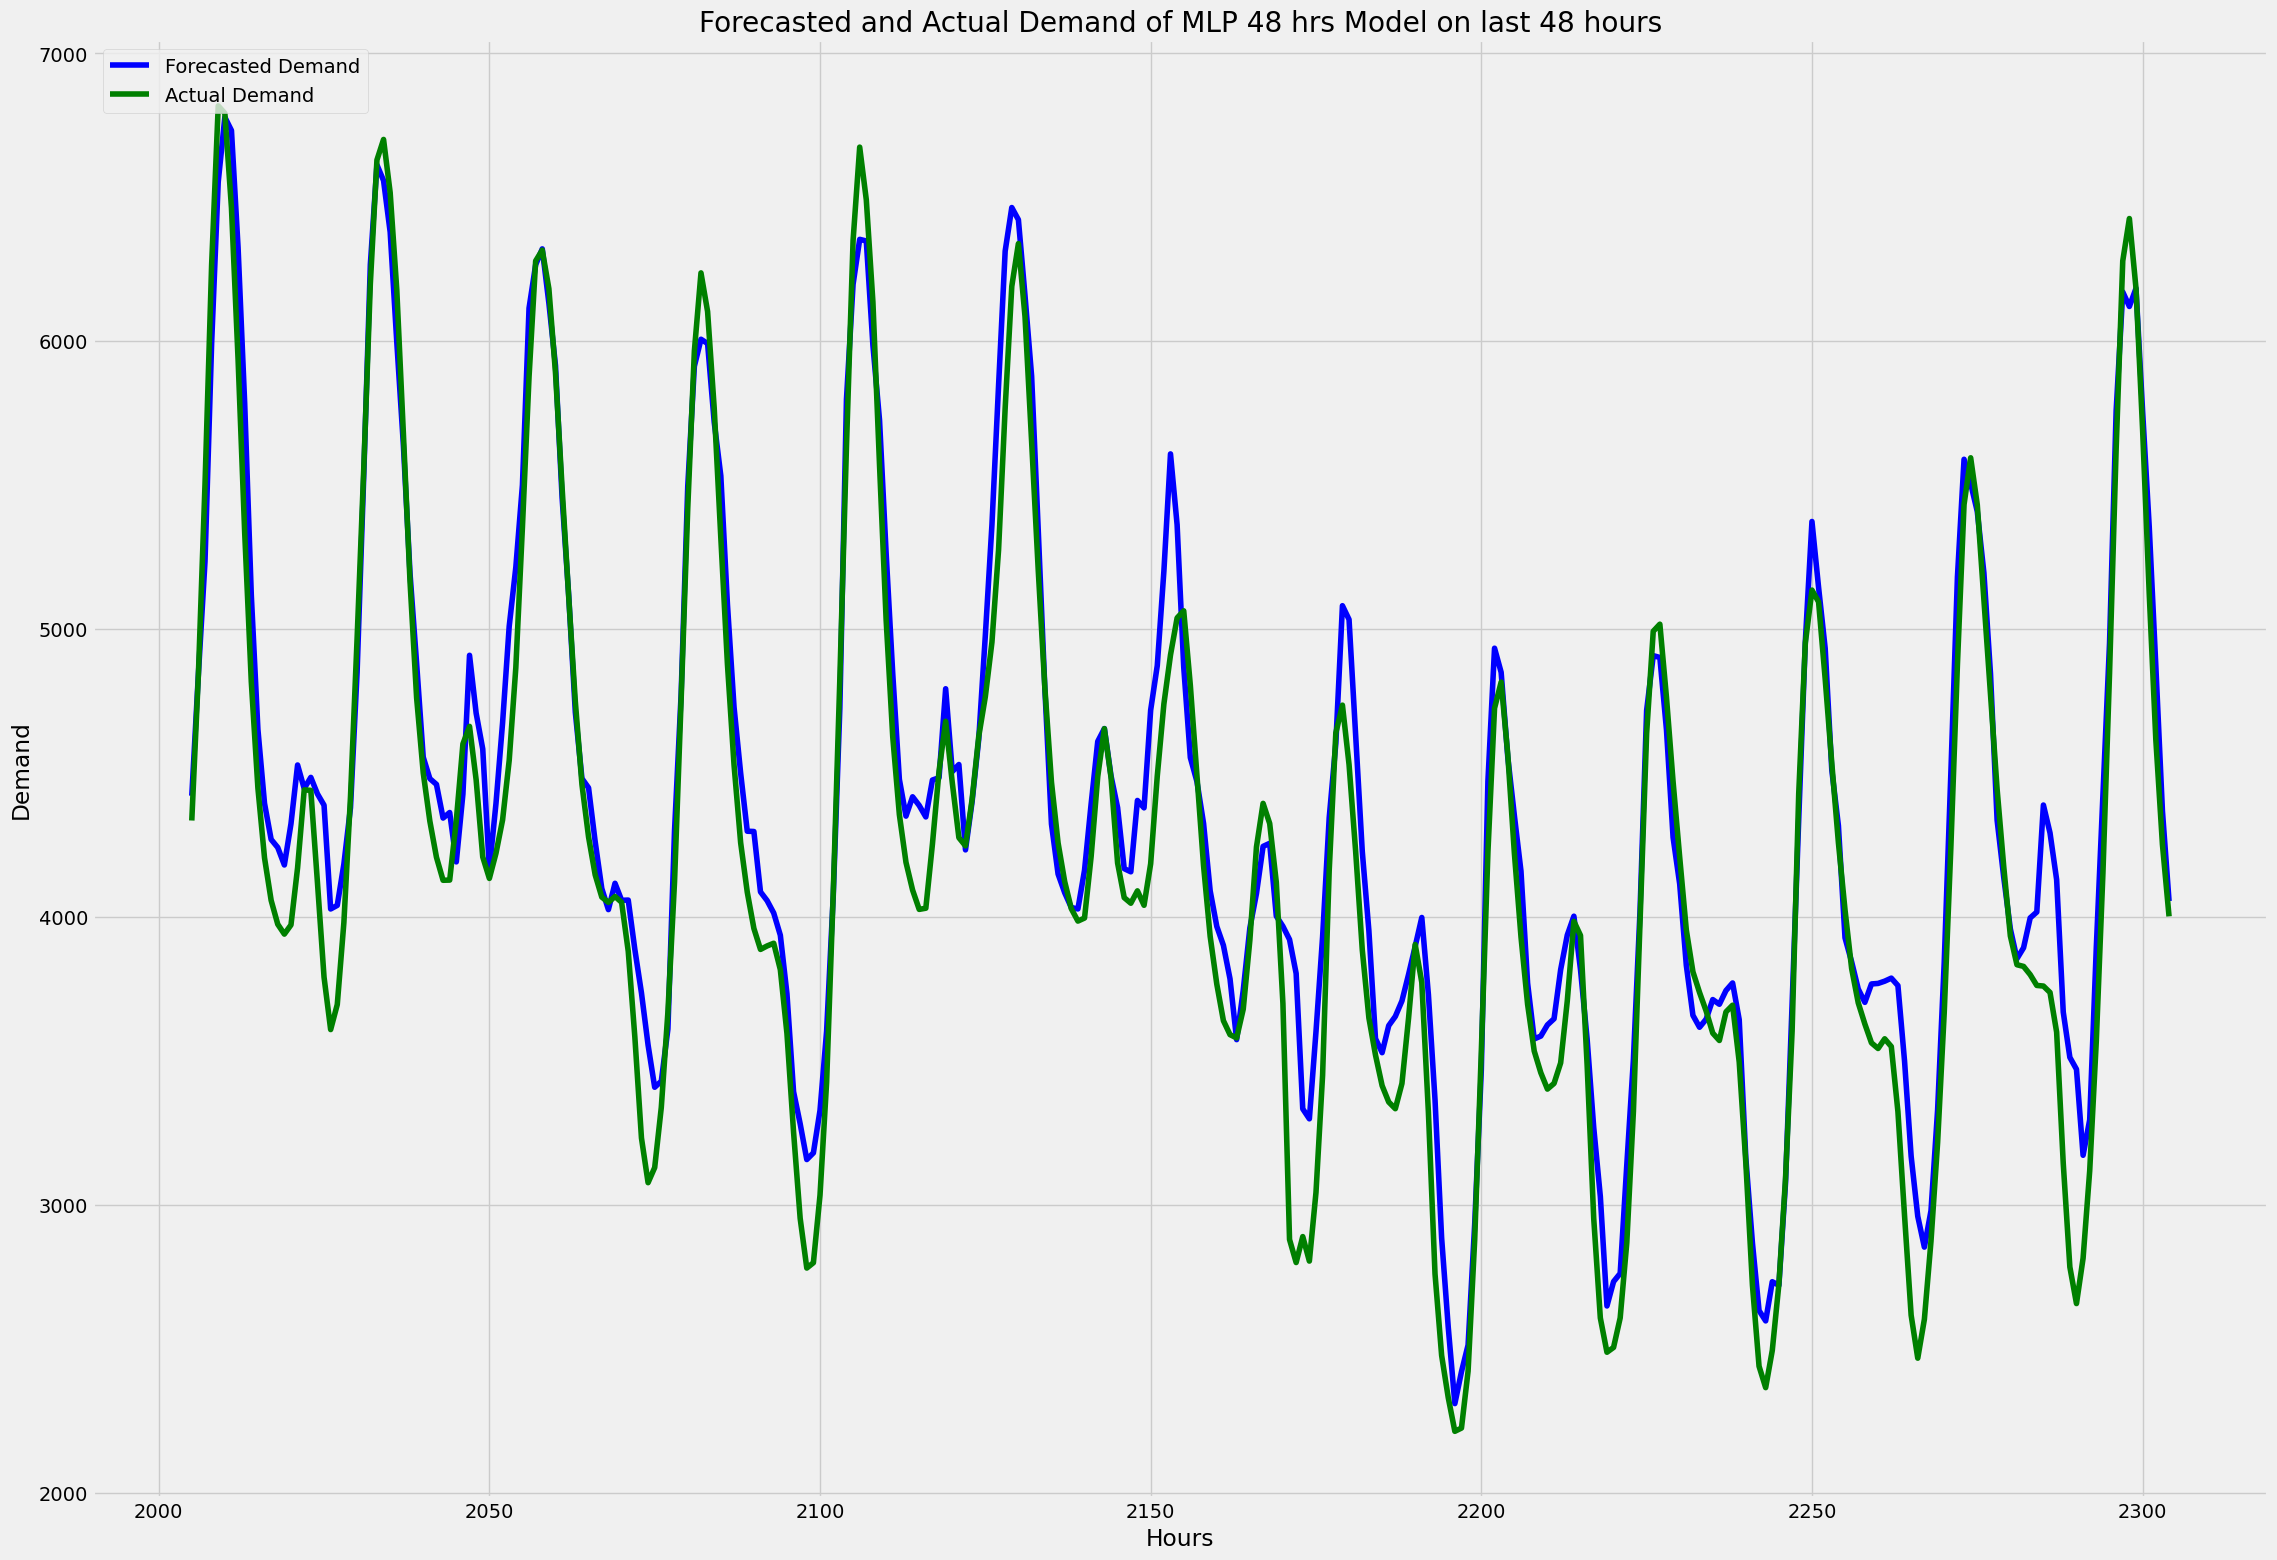

In [75]:
plot_result(final_result["Prediction"][-48:], final_result["Actual"][-48:], 'CNN 48 hrs Model on last 48 hours')

# Test on Summer 2022

In [76]:
new_lag =  lag
lags_list = ['lag' + str(i+1) for i in range(24)]
scaler = StandardScaler()

In [77]:
n_steps_in, n_steps_out = 48,48
X, y = split_sequence_mult(new_lag, n_steps_in=n_steps_in,n_steps_out=n_steps_out)
#flatten inputs
n_inputs, n_out = X.shape[1] * X.shape[2], 48
XM = X.reshape(X.shape[0], n_inputs)
X_train, X_test, y_train, y_test = XM[:-2305], XM[-2305:], y[:-2305], y[-2305:]

In [78]:
y_test

array([[3557.194, 3491.91 , 3446.682, ..., 4320.124, 4014.74 , 3770.444],
       [3491.91 , 3446.682, 3462.622, ..., 4014.74 , 3770.444, 3604.786],
       [3446.682, 3462.622, 3533.076, ..., 3770.444, 3604.786, 3529.854],
       ...,
       [4443.26 , 4174.932, 3933.864, ..., 6038.368, 5602.4  , 5109.266],
       [4174.932, 3933.864, 3833.662, ..., 5602.4  , 5109.266, 4613.252],
       [3933.864, 3833.662, 3827.826, ..., 5109.266, 4613.252, 4249.63 ]])

In [79]:


rn.seed(24)
tf.random.set_seed(24)

MLP_model = Sequential()
MLP_model.add(Dense(900, activation='relu', input_dim=n_inputs))
MLP_model.add(Dense(n_out))
MLP_model.compile(optimizer='adam', loss='mse')
MLP_model.fit(X_train, y_train, epochs=100, verbose=1)
#saving the model


Epoch 1/100
1345/1345 [==============================] - 16s 11ms/step - loss: 415225.8125
Epoch 2/100
1345/1345 [==============================] - 15s 11ms/step - loss: 250128.8906
Epoch 3/100
1345/1345 [==============================] - 14s 11ms/step - loss: 235036.2031
Epoch 4/100
1345/1345 [==============================] - 15s 11ms/step - loss: 226525.9688
Epoch 5/100
1345/1345 [==============================] - 15s 11ms/step - loss: 223571.2812
Epoch 6/100
1345/1345 [==============================] - 15s 11ms/step - loss: 219040.1719
Epoch 7/100
1345/1345 [==============================] - 15s 11ms/step - loss: 215972.5781
Epoch 8/100
1345/1345 [==============================] - 15s 11ms/step - loss: 210496.9844
Epoch 9/100
1345/1345 [==============================] - 15s 11ms/step - loss: 211470.3750
Epoch 10/100
1345/1345 [==============================] - 15s 11ms/step - loss: 207030.2031
Epoch 11/100
1345/1345 [==============================] - 15s 11ms/step - loss: 208378.96

In [80]:
y_test

array([[3557.194, 3491.91 , 3446.682, ..., 4320.124, 4014.74 , 3770.444],
       [3491.91 , 3446.682, 3462.622, ..., 4014.74 , 3770.444, 3604.786],
       [3446.682, 3462.622, 3533.076, ..., 3770.444, 3604.786, 3529.854],
       ...,
       [4443.26 , 4174.932, 3933.864, ..., 6038.368, 5602.4  , 5109.266],
       [4174.932, 3933.864, 3833.662, ..., 5602.4  , 5109.266, 4613.252],
       [3933.864, 3833.662, 3827.826, ..., 5109.266, 4613.252, 4249.63 ]])

In [81]:
yhat=MLP_model.predict(X_test)
test = y_test
metricf(yhat, test)

MAE : 561.949297
MSE : 571832.758286
RMSE : 756.196243
MAPE : 0.125030


In [82]:
#yhat

array([[3456.6162, 3183.627 , 2990.4219, ..., 3832.6333, 3582.5906,
        3392.8696],
       [3306.106 , 3092.469 , 2985.7197, ..., 3518.8083, 3297.1943,
        3139.4338],
       [3243.5613, 3108.8591, 3056.6196, ..., 3240.7957, 3073.0676,
        2972.039 ],
       ...,
       [4439.2812, 4122.9575, 3836.5054, ..., 5137.5845, 4879.968 ,
        4587.665 ],
       [4376.286 , 4099.0884, 3814.3438, ..., 4577.8447, 4273.273 ,
        4079.948 ],
       [4067.0107, 3809.1875, 3614.3665, ..., 4249.701 , 3946.1602,
        3755.2085]], dtype=float32)

In [83]:
pred = array([i for i in yhat]).reshape(-1,1)
tester = array([i for i in test]).reshape(-1,1)
pred = pd.DataFrame(pred)
tester = pd.DataFrame(tester)
result = pd.concat([pred, tester],ignore_index=True, axis=1)
#result[:55]

,0,1
0,3456.616211,3557.194
1,3183.626953,3491.910
2,2990.421875,3446.682
3,2971.062012,3462.622
4,3102.228027,3533.076
5,3261.313721,3629.102
6,3313.911133,3689.648
7,3181.006836,3460.202
8,2889.080566,2903.762
9,2641.899658,2575.900


In [84]:
final_result=result.iloc[::48, :]
final_result.rename(columns={0 : 'Prediction',1: "Actual"}, inplace=True)
#final_result[:15]

,Prediction,Actual
0,3456.616211,3557.194
48,3306.105957,3491.910
96,3243.561279,3446.682
144,3279.072266,3462.622
192,3380.273193,3533.076
240,3417.178955,3629.102
288,3430.013916,3689.648
336,3246.920166,3460.202
384,2947.535645,2903.762
432,2527.517334,2575.900


In [85]:
final_result['date'] = pd.date_range(start='2021-12-01', periods=len(final_result), freq='H')
#final_result

,Prediction,Actual,date
0,3456.616211,3557.194,2021-12-01 00:00:00
48,3306.105957,3491.910,2021-12-01 01:00:00
96,3243.561279,3446.682,2021-12-01 02:00:00
144,3279.072266,3462.622,2021-12-01 03:00:00
192,3380.273193,3533.076,2021-12-01 04:00:00
...,...,...,...
110400,4561.851074,5103.602,2022-03-06 20:00:00
110448,4419.016113,4772.978,2022-03-06 21:00:00
110496,4439.281250,4443.260,2022-03-06 22:00:00
110544,4376.286133,4174.932,2022-03-06 23:00:00


In [86]:
metricf(final_result["Prediction"], final_result["Actual"])

MAE : 211.047353
MSE : 83565.689213
RMSE : 289.077307
MAPE : 0.047317


Accuracy: 0.922018094229534


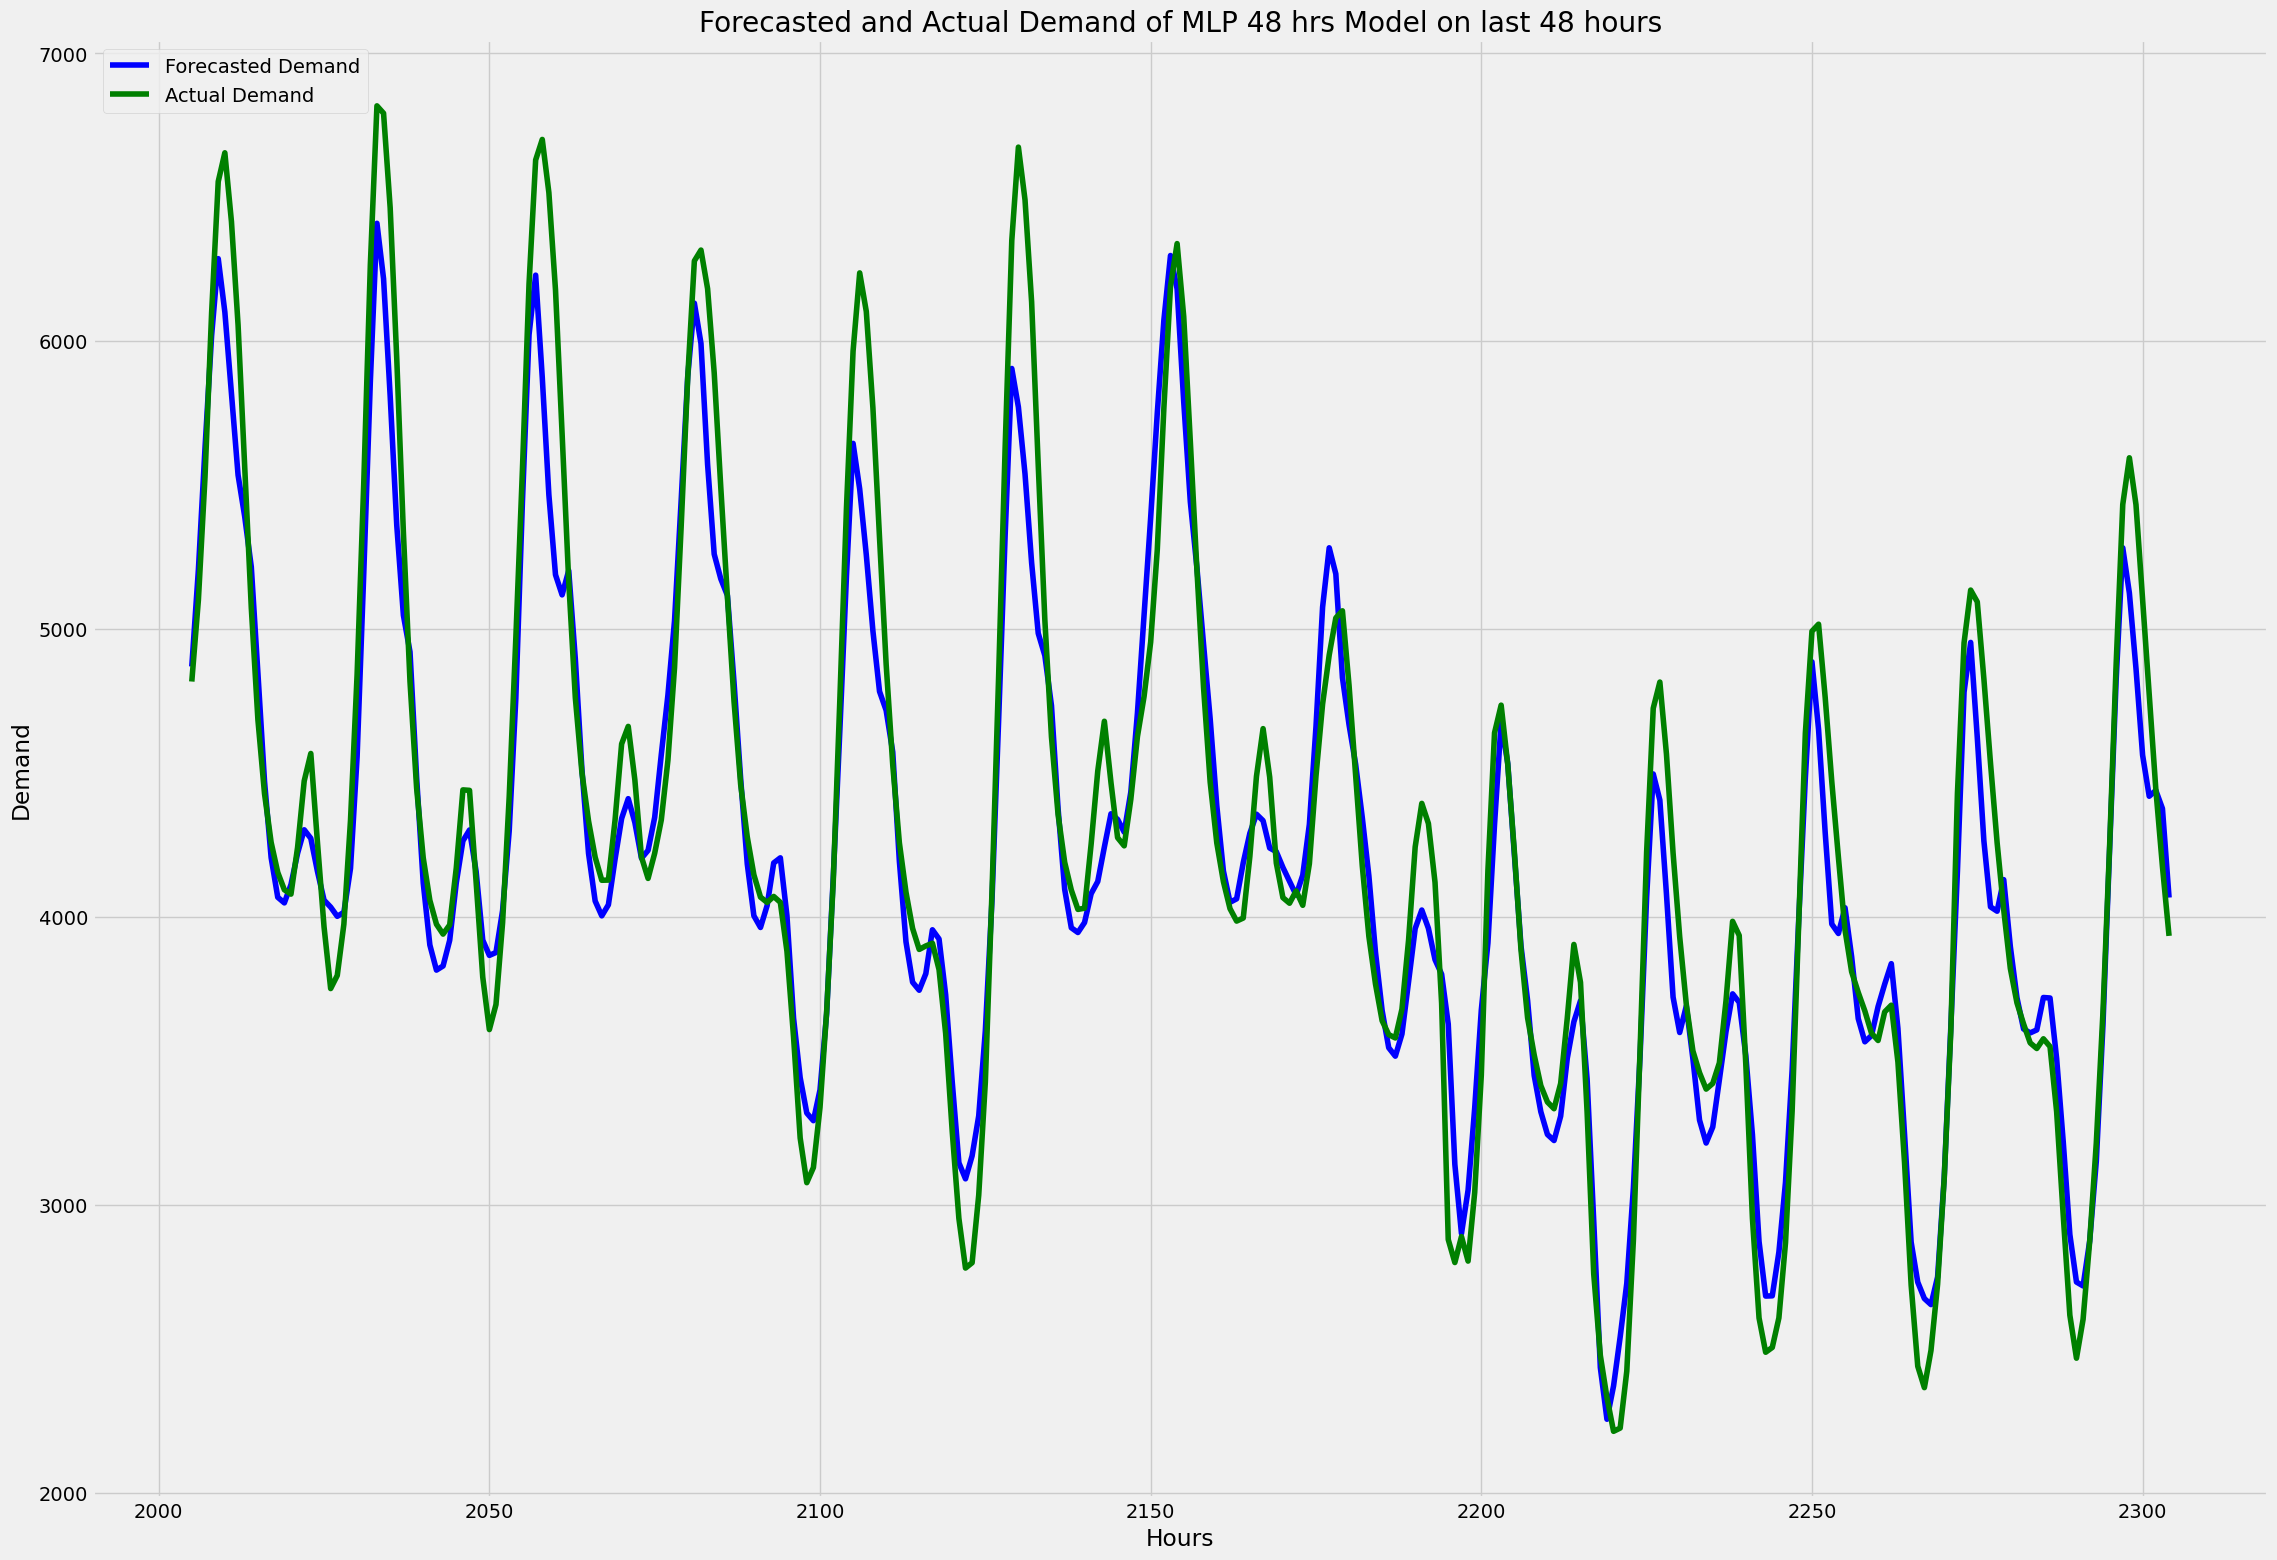

In [87]:
plot_result(final_result["Prediction"][-48:], final_result["Actual"][-48:], 'MLP 48 hrs Model on last 48 hours')

In [88]:
final_result['date'] = pd.to_datetime(final_result['date'])
final_result["Date"] = pd.to_datetime(final_result['date']).dt.date

In [89]:
#final_result

,Prediction,Actual,date,Date
0,3456.616211,3557.194,2021-12-01 00:00:00,2021-12-01
48,3306.105957,3491.910,2021-12-01 01:00:00,2021-12-01
96,3243.561279,3446.682,2021-12-01 02:00:00,2021-12-01
144,3279.072266,3462.622,2021-12-01 03:00:00,2021-12-01
192,3380.273193,3533.076,2021-12-01 04:00:00,2021-12-01
...,...,...,...,...
110400,4561.851074,5103.602,2022-03-06 20:00:00,2022-03-06
110448,4419.016113,4772.978,2022-03-06 21:00:00,2022-03-06
110496,4439.281250,4443.260,2022-03-06 22:00:00,2022-03-06
110544,4376.286133,4174.932,2022-03-06 23:00:00,2022-03-06


In [90]:
agg_1 = pd.DataFrame(final_result.groupby(['Date'])["Prediction"].sum().reset_index())
agg_2= pd.DataFrame(final_result.groupby(['Date'])["Actual"].sum().reset_index())

In [91]:
df_merged = pd.merge(agg_1, agg_2, on='Date', how='inner')
df_merged
#

,Date,Prediction,Actual
0,2021-12-01,79265.703125,81389.002
1,2021-12-02,81422.578125,83692.208
2,2021-12-03,84974.335938,87674.768
3,2021-12-04,84985.312500,86230.014
4,2021-12-05,84063.539062,83724.146
...,...,...,...
92,2022-03-03,80734.093750,82703.590
93,2022-03-04,86385.273438,87786.444
94,2022-03-05,88163.375000,89077.488
95,2022-03-06,92704.726562,93176.432


In [92]:
#df_merged[df_merged["Prediction"].gt(136663)]

,Date,Prediction,Actual
26,2021-12-27,136746.203125,139702.954
49,2022-01-19,140792.734375,143929.714
65,2022-02-04,139726.968750,142620.646
77,2022-02-16,138337.531250,143068.538


In [93]:
#df_merged.sort_values(by=['Prediction']).tail(5)

,Date,Prediction,Actual
51,2022-01-21,135991.968750,141839.600
26,2021-12-27,136746.203125,139702.954
77,2022-02-16,138337.531250,143068.538
65,2022-02-04,139726.968750,142620.646
49,2022-01-19,140792.734375,143929.714


In [94]:
#df_merged["Prediction"].nlargest(n=5)

49    140792.734375
65    139726.968750
77    138337.531250
26    136746.203125
51    135991.968750
Name: Prediction, dtype: float32

In [95]:
#df_merged.sort_values(by=['Actual']).tail(5)

,Date,Prediction,Actual
26,2021-12-27,136746.203125,139702.954
51,2022-01-21,135991.968750,141839.600
65,2022-02-04,139726.968750,142620.646
77,2022-02-16,138337.531250,143068.538
49,2022-01-19,140792.734375,143929.714


# CNN model

In [102]:
n_in, n_out = 48, 48
#X,y = split_sequence_mult(lag,n_in, n_out)

X_train, X_test, y_train, y_test = split_data_fcast(X,y)

rn.seed(24)
tf.random.set_seed(24)


n_features = 29

In [103]:
y_test

array([[3557.194, 3491.91 , 3446.682, ..., 4320.124, 4014.74 , 3770.444],
       [3491.91 , 3446.682, 3462.622, ..., 4014.74 , 3770.444, 3604.786],
       [3446.682, 3462.622, 3533.076, ..., 3770.444, 3604.786, 3529.854],
       ...,
       [4443.26 , 4174.932, 3933.864, ..., 6038.368, 5602.4  , 5109.266],
       [4174.932, 3933.864, 3833.662, ..., 5602.4  , 5109.266, 4613.252],
       [3933.864, 3833.662, 3827.826, ..., 5109.266, 4613.252, 4249.63 ]])

In [104]:
X_train.shape

(43009, 48, 29)

In [105]:


# define model
CNN_model = Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_in,
n_features)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(800, activation='relu'))
CNN_model.add(Dense(n_out))
CNN_model.compile(optimizer='adam', loss='mse')
# fit model
CNN_model.fit(X_train, y_train, epochs=600, verbose=1)

Epoch 1/600
1345/1345 [==============================] - 25s 18ms/step - loss: 277105.8750
Epoch 2/600
1345/1345 [==============================] - 24s 18ms/step - loss: 198297.4688
Epoch 3/600
1345/1345 [==============================] - 25s 18ms/step - loss: 185448.0625
Epoch 4/600
1345/1345 [==============================] - 25s 19ms/step - loss: 175858.7969
Epoch 5/600
1345/1345 [==============================] - 25s 18ms/step - loss: 169466.1250
Epoch 6/600
1345/1345 [==============================] - 24s 18ms/step - loss: 163682.2344
Epoch 7/600
1345/1345 [==============================] - 25s 18ms/step - loss: 157729.0312
Epoch 8/600
1345/1345 [==============================] - 23s 17ms/step - loss: 153665.4375
Epoch 9/600
1345/1345 [==============================] - 22s 16ms/step - loss: 151363.1562
Epoch 10/600
1345/1345 [==============================] - 24s 18ms/step - loss: 146461.3750
Epoch 11/600
1345/1345 [==============================] - 24s 18ms/step - loss: 145412.79

1345/1345 [==============================] - 16s 12ms/step - loss: 87721.7422
Epoch 180/600
1345/1345 [==============================] - 13s 10ms/step - loss: 87173.9297
Epoch 181/600
1345/1345 [==============================] - 12s 9ms/step - loss: 86934.4688
Epoch 182/600
1345/1345 [==============================] - 14s 10ms/step - loss: 86879.8203
Epoch 183/600
1345/1345 [==============================] - 17s 12ms/step - loss: 87485.0000
Epoch 184/600
1345/1345 [==============================] - 15s 11ms/step - loss: 88828.2969
Epoch 185/600
1345/1345 [==============================] - 15s 11ms/step - loss: 86782.6250
Epoch 186/600
1345/1345 [==============================] - 14s 10ms/step - loss: 86598.0234
Epoch 187/600
1345/1345 [==============================] - 16s 12ms/step - loss: 87095.6094
Epoch 188/600
1345/1345 [==============================] - 19s 14ms/step - loss: 86522.9453
Epoch 189/600
1345/1345 [==============================] - 18s 13ms/step - loss: 86847.0078
Epo

1345/1345 [==============================] - 14s 10ms/step - loss: 79069.6641
Epoch 358/600
1345/1345 [==============================] - 13s 10ms/step - loss: 79479.0234
Epoch 359/600
1345/1345 [==============================] - 18s 14ms/step - loss: 79657.4219
Epoch 360/600
1345/1345 [==============================] - 20s 15ms/step - loss: 79433.4219
Epoch 361/600
1345/1345 [==============================] - 16s 12ms/step - loss: 79361.3516
Epoch 362/600
1345/1345 [==============================] - 17s 13ms/step - loss: 78829.0078
Epoch 363/600
1345/1345 [==============================] - 18s 13ms/step - loss: 78747.3281
Epoch 364/600
1345/1345 [==============================] - 15s 12ms/step - loss: 78790.8906
Epoch 365/600
1345/1345 [==============================] - 17s 13ms/step - loss: 78738.0156
Epoch 366/600
1345/1345 [==============================] - 13s 10ms/step - loss: 78786.4531
Epoch 367/600
1345/1345 [==============================] - 16s 12ms/step - loss: 79800.9375
Ep

1345/1345 [==============================] - 16s 12ms/step - loss: 75871.9453
Epoch 536/600
1345/1345 [==============================] - 15s 11ms/step - loss: 76084.4844
Epoch 537/600
1345/1345 [==============================] - 14s 11ms/step - loss: 76135.1641
Epoch 538/600
1345/1345 [==============================] - 15s 11ms/step - loss: 75259.7500
Epoch 539/600
1345/1345 [==============================] - 17s 13ms/step - loss: 75476.4453
Epoch 540/600
1345/1345 [==============================] - 15s 11ms/step - loss: 76395.7031
Epoch 541/600
1345/1345 [==============================] - 14s 10ms/step - loss: 75874.5547
Epoch 542/600
1345/1345 [==============================] - 16s 12ms/step - loss: 75145.9062
Epoch 543/600
1345/1345 [==============================] - 14s 11ms/step - loss: 76255.1172
Epoch 544/600
1345/1345 [==============================] - 14s 11ms/step - loss: 75185.7344
Epoch 545/600
1345/1345 [==============================] - 14s 10ms/step - loss: 76248.5547
Ep

In [185]:
yhat=CNN_model.predict(X_test)
test = y_test
metricf(yhat, test)

MAE : 545.864340
MSE : 588449.259774
RMSE : 767.104465
MAPE : 0.125105


In [186]:
pred = array([i for i in yhat]).reshape(-1,1)
tester = array([i for i in test]).reshape(-1,1)
pred = pd.DataFrame(pred)
tester = pd.DataFrame(tester)
result = pd.concat([pred, tester],ignore_index=True, axis=1)

In [187]:
final_result=result.iloc[::48, :]
final_result.rename(columns={0 : 'Prediction',1: "Actual"}, inplace=True)

In [188]:
final_result['date'] = pd.date_range(start='2021-12-01', periods=len(final_result), freq='H')
final_result

,Prediction,Actual,date
0,3683.812256,3557.194,2021-12-01 00:00:00
48,3554.653564,3491.910,2021-12-01 01:00:00
96,3484.271973,3446.682,2021-12-01 02:00:00
144,3465.727051,3462.622,2021-12-01 03:00:00
192,3329.837402,3533.076,2021-12-01 04:00:00
...,...,...,...
110400,4881.192383,5103.602,2022-03-06 20:00:00
110448,4591.620605,4772.978,2022-03-06 21:00:00
110496,4208.449707,4443.260,2022-03-06 22:00:00
110544,3890.855469,4174.932,2022-03-06 23:00:00


In [189]:
final_result['date'] = pd.to_datetime(final_result['date'])
final_result["Date"] = pd.to_datetime(final_result['date']).dt.date

In [190]:
agg_1 = pd.DataFrame(final_result.groupby(['Date'])["Prediction"].sum().reset_index())
agg_2= pd.DataFrame(final_result.groupby(['Date'])["Actual"].sum().reset_index())

In [191]:
df_merged = pd.merge(agg_1, agg_2, on='Date', how='inner')
#df_merged

,Date,Prediction,Actual
0,2021-12-01,80253.203125,81389.002
1,2021-12-02,80547.015625,83692.208
2,2021-12-03,83965.156250,87674.768
3,2021-12-04,84863.476562,86230.014
4,2021-12-05,82628.070312,83724.146
...,...,...,...
92,2022-03-03,81756.859375,82703.590
93,2022-03-04,84919.242188,87786.444
94,2022-03-05,85617.585938,89077.488
95,2022-03-06,90469.953125,93176.432


In [192]:
metricf(final_result["Prediction"], final_result["Actual"])

MAE : 253.263603
MSE : 108148.535695
RMSE : 328.859447
MAPE : 0.059561


Accuracy: 0.912886653452736


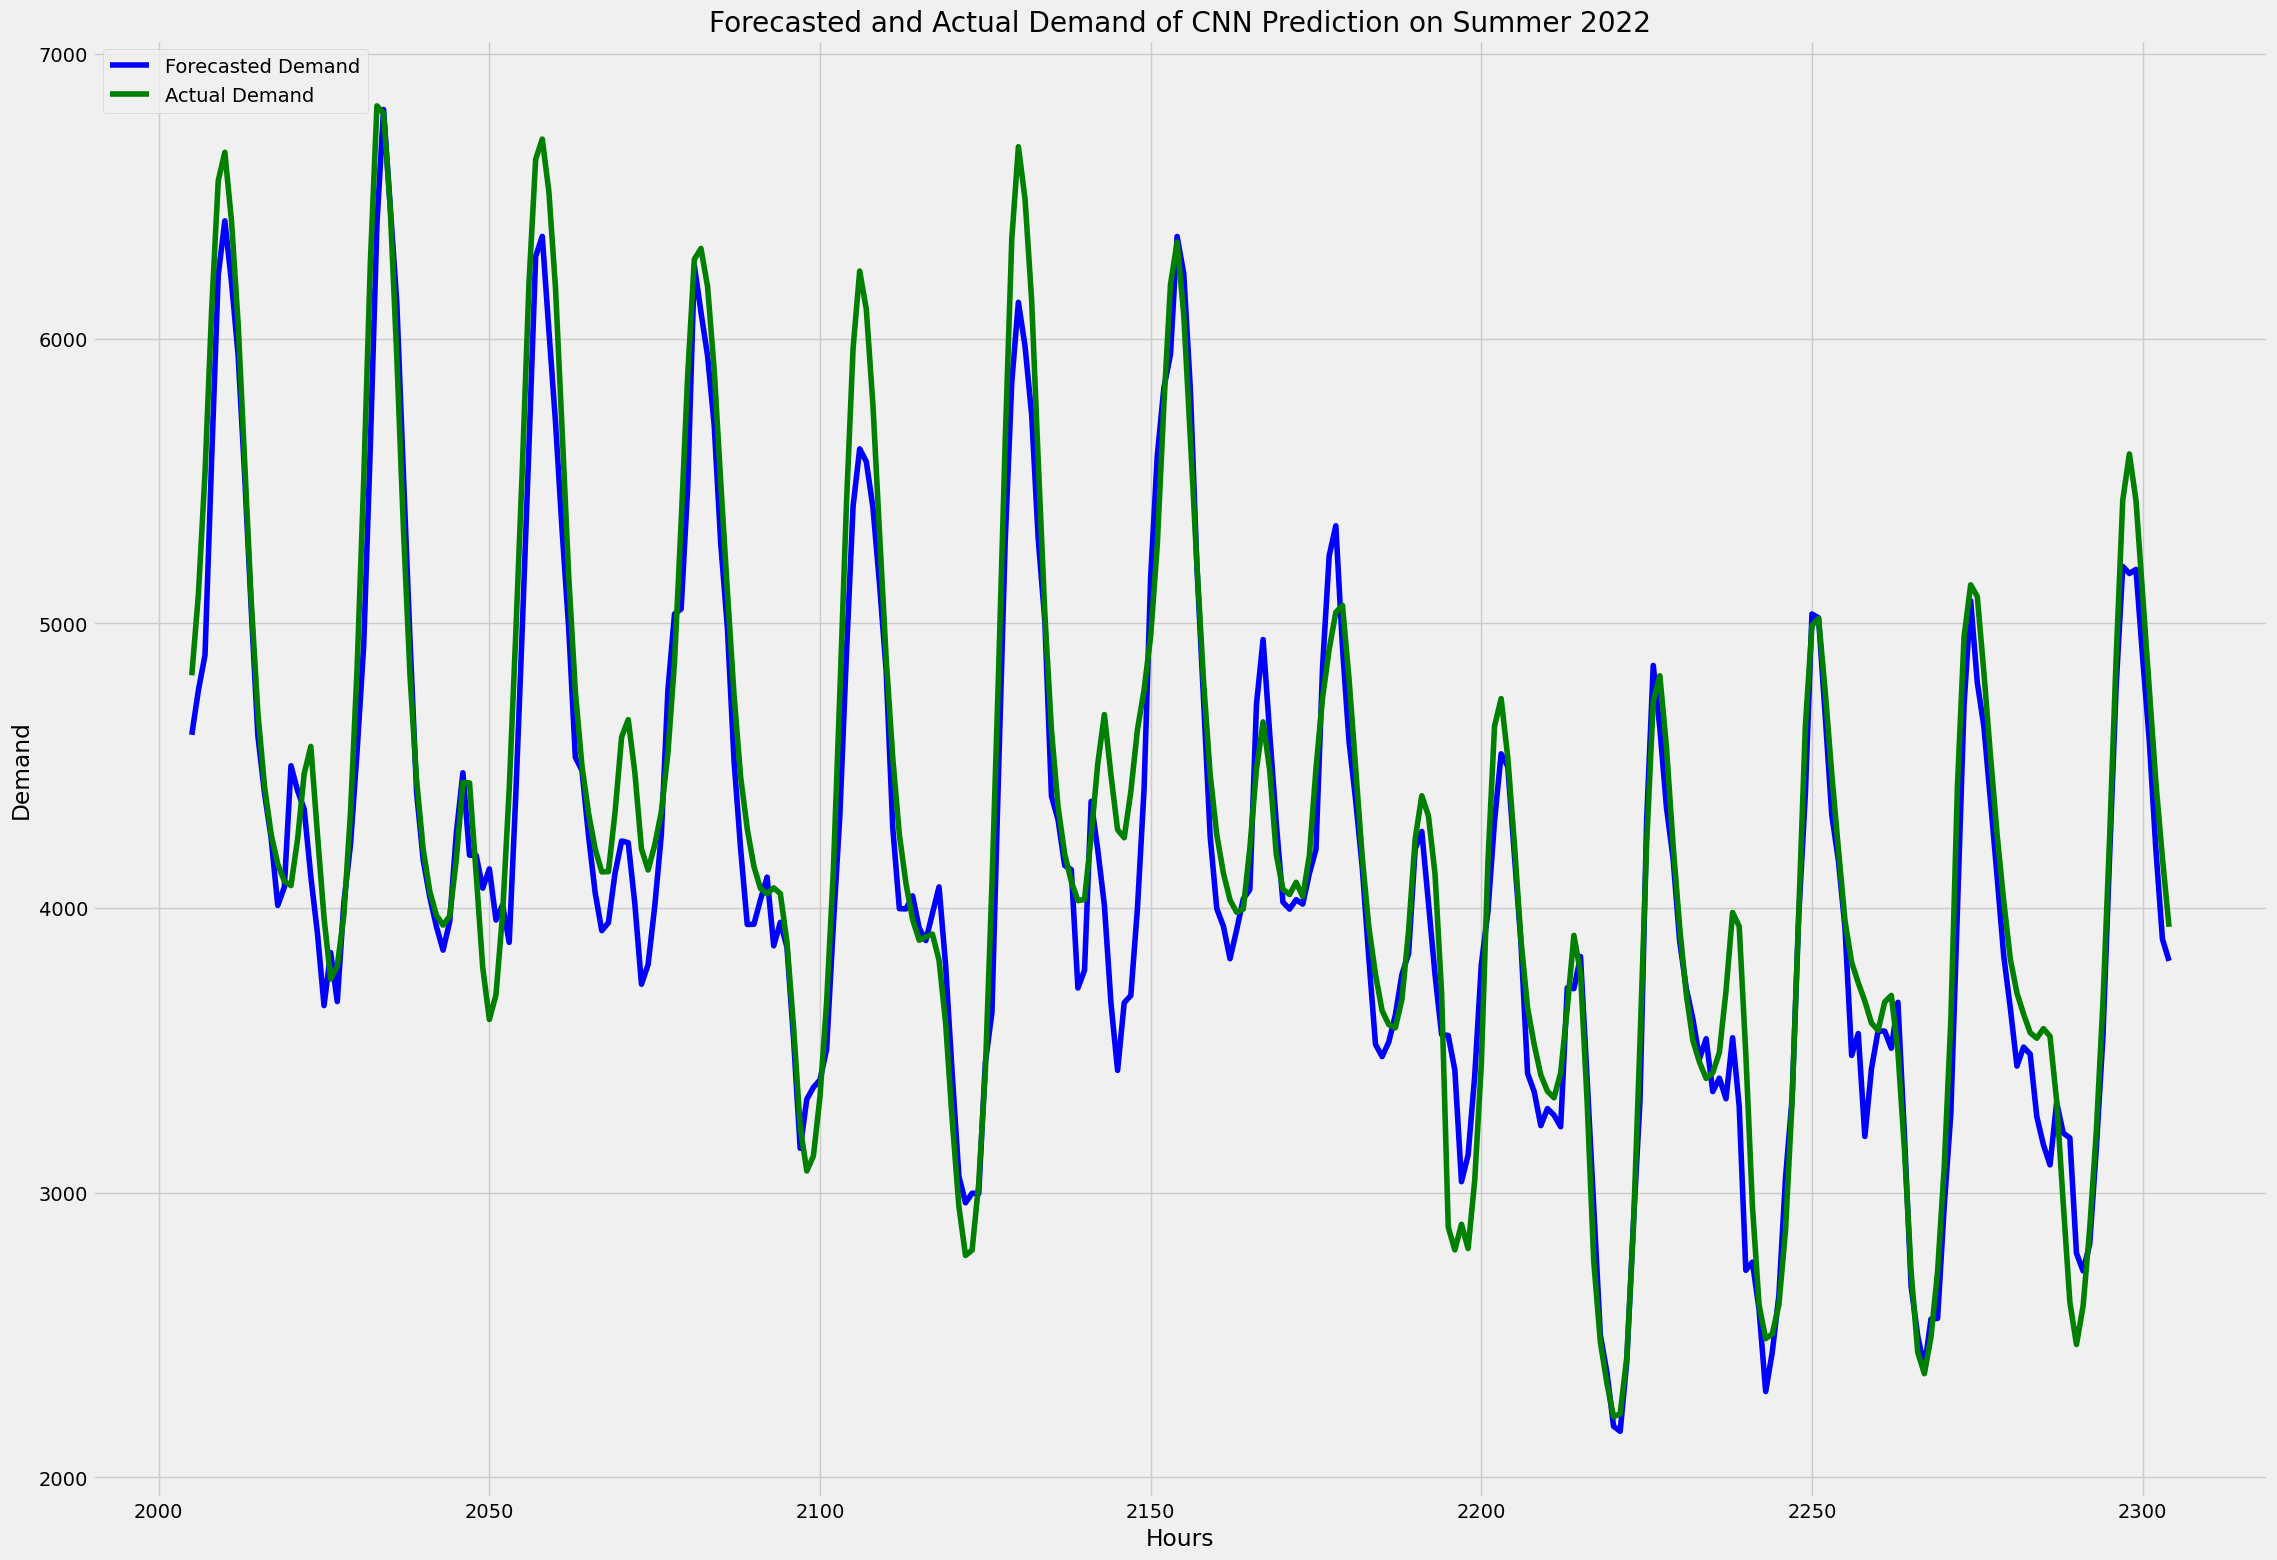

In [193]:
plot_result(final_result["Prediction"][-48:], final_result["Actual"][-48:], 'CNN 48 hrs Model on last 48 hours')

In [230]:
### Converting predicted values into classes using threshold
threshold=133490

predicted_class1=np.zeros(df_merged["Prediction"].shape)
predicted_class1[df_merged["Prediction"]>threshold]=1
#predicted_class1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [231]:
actual_class1=np.zeros(df_merged["Actual"].shape)
actual_class1[df_merged["Actual"]>threshold]=1
actual=pd.DataFrame(actual_class1)


In [232]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(actual,predicted_class1)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[87  0]
 [ 6  4]]
Accuracy :  0.9381443298969072
Sensitivity :  1.0
Specificity :  0.4


In [213]:
df_merged[df_merged["Prediction"].gt(133701)]

,Date,Prediction,Actual
49,2022-01-19,135835.140625,143929.714
51,2022-01-21,134440.937500,141839.600
65,2022-02-04,134152.312500,142620.646
77,2022-02-16,136984.218750,143068.538


In [227]:
df_merged.sort_values(by=['Prediction']).tail(7)

,Date,Prediction,Actual
52,2022-01-22,130840.851562,134182.038
50,2022-01-20,132927.562500,139644.016
76,2022-02-15,133284.437500,137116.820
65,2022-02-04,134152.312500,142620.646
51,2022-01-21,134440.937500,141839.600
49,2022-01-19,135835.140625,143929.714
77,2022-02-16,136984.218750,143068.538


In [215]:
df_merged["Prediction"].nlargest(n=5)

77    136984.218750
49    135835.140625
51    134440.937500
65    134152.312500
76    133284.437500
Name: Prediction, dtype: float32

In [216]:
df_merged.sort_values(by=['Actual']).tail(5)

,Date,Prediction,Actual
26,2021-12-27,130242.679688,139702.954
51,2022-01-21,134440.937500,141839.600
65,2022-02-04,134152.312500,142620.646
77,2022-02-16,136984.218750,143068.538
49,2022-01-19,135835.140625,143929.714


# Calculation for Threshold

In [149]:

df1["date"] = pd.to_datetime(df1['Date']).dt.date
df1['date'] = pd.to_datetime(df1['date'])


In [148]:
start_date = '2020-12-01'
end_date = '2021-03-31'
# Select DataFrame rows between two dates
mask = (df1['date'] >=start_date) & (df1['date'] <= end_date)
df2 = df1.loc[mask]


In [145]:
summer_demand_daily = pd.DataFrame(df2.groupby(['date'])["demand"].sum().reset_index())
#summer_demand_daily

In [228]:
q=pd.DataFrame(summer_demand_daily.sort_values(by=['demand']).tail(5).reset_index())
q['date'] = pd.to_datetime(q['date'])


In [284]:
q1=np.percentile(q['demand'], 95)
#q1